## Analyse Israel vaccine efficacy

In [1]:
import pandas as pd
import sys
sys.path.append("../")
import numpy as np
pd.set_option('display.max_rows', 500)
from datetime import datetime, timedelta
from utils import createXYPlot
import subprocess

#### Download data from
Events: https://data.gov.il/dataset/covid-19/resource/8a51c65b-f95a-4fb8-bd97-65f47109f41f

In [2]:
df=pd.read_csv("./data/event-among-vaccinated-25.csv")
df["event_2nd_dose"] = df["event_after_2nd_dose"].apply(lambda x: 4.0 if x == "<5" else float(x))
df["event_1st_dose"] = df["event_after_1st_dose"].apply(lambda x: 4.0 if x == "<5" else float(x))
df["event_no_vax"] = df["event_for_not_vaccinated"].apply(lambda x: 4.0 if x == "<5" else float(x))
df["first_day"] = df["Week"].apply(lambda x: x.split(" - ")[0])
df["last_day"] = df["Week"].apply(lambda x: x.split(" - ")[1])
df=df.fillna(0)
df["over_60"]=df["Age_group"].apply(lambda x: True if x in ('60-69','70-79','80-89','90+') else False)
df = df.rename(columns={"Age_group":"age_group",
                        "Week":"week",
                       "Type_of_event":"type_of_event"})
df = df[["week","first_day","last_day","age_group","type_of_event","event_1st_dose","event_2nd_dose","event_no_vax"]]

In [3]:
df

,week,first_day,last_day,age_group,type_of_event,event_1st_dose,event_2nd_dose,event_no_vax
0,2020-12-20 - 2020-12-26,2020-12-20,2020-12-26,0-19,Hospitalization,0.0,0.0,56.0
1,2020-12-20 - 2020-12-26,2020-12-20,2020-12-26,0-19,Death,0.0,0.0,0.0
2,2020-12-20 - 2020-12-26,2020-12-20,2020-12-26,20-29,Hospitalization,0.0,0.0,50.0
3,2020-12-20 - 2020-12-26,2020-12-20,2020-12-26,20-29,Death,0.0,0.0,4.0
4,2020-12-20 - 2020-12-26,2020-12-20,2020-12-26,30-39,Hospitalization,0.0,0.0,79.0
...,...,...,...,...,...,...,...,...
517,2021-07-04 - 2021-07-10,2021-07-04,2021-07-10,70-79,Death,0.0,4.0,0.0
518,2021-07-04 - 2021-07-10,2021-07-04,2021-07-10,80-89,Hospitalization,0.0,9.0,4.0
519,2021-07-04 - 2021-07-10,2021-07-04,2021-07-10,80-89,Death,0.0,4.0,0.0
520,2021-07-04 - 2021-07-10,2021-07-04,2021-07-10,90+,Hospitalization,0.0,4.0,0.0


In [4]:
last_day=str(np.max(df["last_day"]))
print(f"Last available data: {last_day}")

Last available data: 2021-07-10


In [5]:
print("Creating plot folder")
plot_folder = f"./plots/{last_day}"
subprocess.run(f"mkdir -p {plot_folder}", shell=True)

Creating plot folder


CompletedProcess(args='mkdir -p ./plots/2021-07-10', returncode=0)

In [6]:
types = df.type_of_event.unique()
print(f"Types of event: {types}")

Types of event: ['Hospitalization' 'Death']


In [7]:
df_events = {}
for event in types:
    df_events[event] = df[df.type_of_event==event].groupby(["first_day", "last_day"]).agg(
        vax_1st_dose=("event_1st_dose","sum"),
        vax_2nd_dose=("event_2nd_dose","sum"),
        no_vax=("event_no_vax","sum"),
    ).reset_index() 

In [8]:
df_events["Hospitalization"]

,first_day,last_day,vax_1st_dose,vax_2nd_dose,no_vax
0,2020-12-20,2020-12-26,12.0,0.0,1041.0
1,2020-12-27,2021-01-02,83.0,0.0,1181.0
2,2021-01-03,2021-01-09,438.0,0.0,1256.0
3,2021-01-10,2021-01-16,694.0,4.0,1119.0
4,2021-01-17,2021-01-23,584.0,46.0,1114.0
5,2021-01-24,2021-01-30,340.0,147.0,992.0
6,2021-01-31,2021-02-06,260.0,166.0,1080.0
7,2021-02-07,2021-02-13,185.0,110.0,1000.0
8,2021-02-14,2021-02-20,139.0,89.0,862.0
9,2021-02-21,2021-02-27,161.0,81.0,817.0


In [9]:
df_events["Death"]

,first_day,last_day,vax_1st_dose,vax_2nd_dose,no_vax
0,2020-12-20,2020-12-26,0.0,0.0,137.0
1,2020-12-27,2021-01-02,4.0,0.0,190.0
2,2021-01-03,2021-01-09,23.0,0.0,230.0
3,2021-01-10,2021-01-16,111.0,0.0,243.0
4,2021-01-17,2021-01-23,153.0,8.0,219.0
5,2021-01-24,2021-01-30,159.0,25.0,215.0
6,2021-01-31,2021-02-06,121.0,57.0,175.0
7,2021-02-07,2021-02-13,62.0,52.0,146.0
8,2021-02-14,2021-02-20,55.0,29.0,137.0
9,2021-02-21,2021-02-27,41.0,25.0,130.0


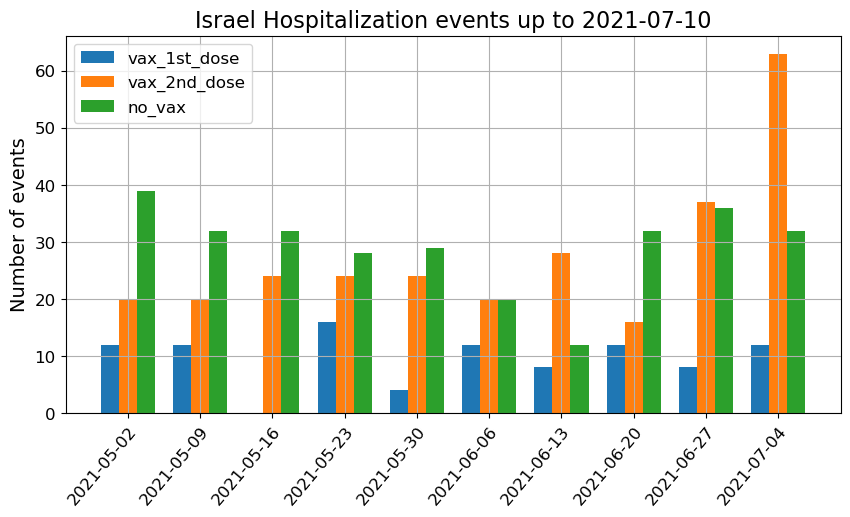

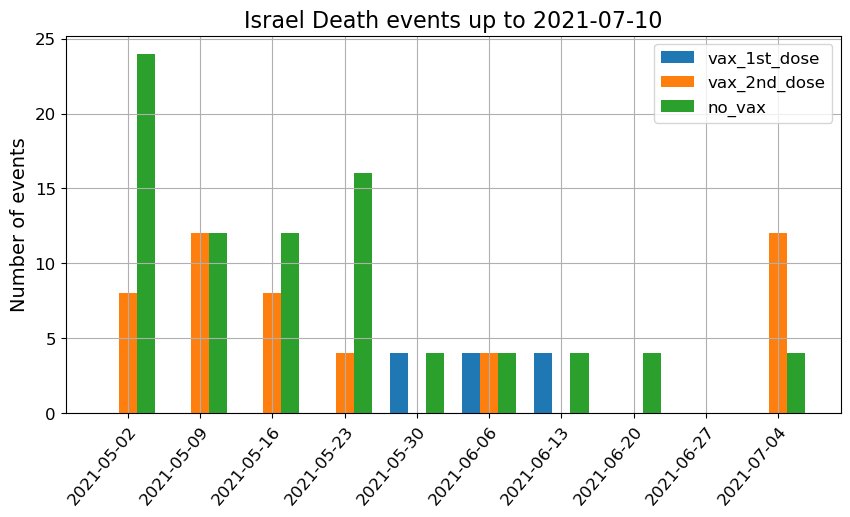

In [11]:
for event in types:
    createXYPlot(df_events[event],
                 y=["vax_1st_dose",
                    "vax_2nd_dose",
                    "no_vax"],
                 today=last_day,
                 plots_folder=plot_folder,
                 x="first_day",
                 linewidth=2,
                 start_date="2021-05-01",
                 days_interval=1,
                 bar=True,
                 alpha=1,
                 bar_width=0.25,
                 bar_start=[-1,0,1],
                 title=f"Israel {event} events up to {last_day}",
                 xtitle=None,
                 ytitle="Number of events",
                 savename=f"Israel_{event}_events_vax"
                )

### Split by age groups

In [14]:
df_events_age = {}
for event in types:
    df_events_age[event] = df[df.type_of_event==event].groupby(["first_day", "last_day", "age_group"]).agg(
        vax_1st_dose=("event_1st_dose","sum"),
        vax_2nd_dose=("event_2nd_dose","sum"),
        no_vax=("event_no_vax","sum"),
    ).reset_index()


In [16]:
df_events_age["Death"]

,first_day,last_day,age_group,vax_1st_dose,vax_2nd_dose,no_vax
0,2020-12-20,2020-12-26,0-19,0.0,0.0,0.0
1,2020-12-20,2020-12-26,20-29,0.0,0.0,4.0
2,2020-12-20,2020-12-26,30-39,0.0,0.0,0.0
3,2020-12-20,2020-12-26,40-49,0.0,0.0,4.0
4,2020-12-20,2020-12-26,50-59,0.0,0.0,8.0
5,2020-12-20,2020-12-26,60-69,0.0,0.0,26.0
6,2020-12-20,2020-12-26,70-79,0.0,0.0,31.0
7,2020-12-20,2020-12-26,80-89,0.0,0.0,44.0
8,2020-12-20,2020-12-26,90+,0.0,0.0,20.0
9,2020-12-27,2021-01-02,0-19,0.0,0.0,0.0


### Vaccinations per day - age_group

In [25]:
df_vax_age = pd.read_csv("./data/vaccinated-per-day-2021-07-13.csv")

In [27]:
df_vax_age["week"] = ((pd.to_datetime(df_vax_age["VaccinationDate"]) - pd.to_datetime("2020-12-20")).dt.days / 7).astype(int)
df_vax_age["first_dose"] = df_vax_age["first_dose"].apply(lambda x: int(x.replace("<","")) - 1 if "<" in x else int(x))
df_vax_age["second_dose"] = df_vax_age["second_dose"].apply(lambda x: int(x.replace("<","")) - 1 if "<" in x else int(x))

In [28]:
df_vax_age

,VaccinationDate,age_group,first_dose,second_dose,week
0,2020-12-20,20-29,392,0,0
1,2020-12-20,80-89,93,0,0
2,2020-12-20,0-19,21,0,0
3,2020-12-20,60-69,1516,0,0
4,2020-12-20,50-59,1786,0,0
...,...,...,...,...,...
1836,2021-07-13,70-79,31,27,29
1837,2021-07-13,90+,14,14,29
1838,2021-07-13,80-89,17,16,29
1839,2021-07-13,0-19,1501,4296,29


#### Create grid of dates in case some are missing

In [35]:
min_yyyy_mm_dd = datetime.strptime(np.min(df_vax_age["VaccinationDate"]),"%Y-%m-%d")
max_yyyy_mm_dd = datetime.strptime(np.max(df_vax_age["VaccinationDate"]),"%Y-%m-%d")

all_yyy_mm_dd = pd.DataFrame([str(i.date()) for i in pd.date_range(min_yyyy_mm_dd, max_yyyy_mm_dd+timedelta(days=1),freq='d')], columns=["VaccinationDate"])
age_groups = df_vax_age["age_group"].unique()
all_age_groups = pd.DataFrame(age_groups,columns=["age_group"])

In [36]:
all_yyy_mm_dd["key"]=0
all_age_groups["key"]=0
all_yyy_mm_dd=all_yyy_mm_dd.set_index("key")
all_age_groups=all_age_groups.set_index("key")
df_grid=all_yyy_mm_dd.join(all_age_groups).sort_values(by=["VaccinationDate","age_group"]).set_index(["VaccinationDate","age_group"])

In [37]:
df_grid

Empty DataFrame
Columns: []
Index: [(2020-12-20, 0-19), (2020-12-20, 20-29), (2020-12-20, 30-39), (2020-12-20, 40-49), (2020-12-20, 50-59), (2020-12-20, 60-69), (2020-12-20, 70-79), (2020-12-20, 80-89), (2020-12-20, 90+), (2020-12-21, 0-19), (2020-12-21, 20-29), (2020-12-21, 30-39), (2020-12-21, 40-49), (2020-12-21, 50-59), (2020-12-21, 60-69), (2020-12-21, 70-79), (2020-12-21, 80-89), (2020-12-21, 90+), (2020-12-22, 0-19), (2020-12-22, 20-29), (2020-12-22, 30-39), (2020-12-22, 40-49), (2020-12-22, 50-59), (2020-12-22, 60-69), (2020-12-22, 70-79), (2020-12-22, 80-89), (2020-12-22, 90+), (2020-12-23, 0-19), (2020-12-23, 20-29), (2020-12-23, 30-39), (2020-12-23, 40-49), (2020-12-23, 50-59), (2020-12-23, 60-69), (2020-12-23, 70-79), (2020-12-23, 80-89), (2020-12-23, 90+), (2020-12-24, 0-19), (2020-12-24, 20-29), (2020-12-24, 30-39), (2020-12-24, 40-49), (2020-12-24, 50-59), (2020-12-24, 60-69), (2020-12-24, 70-79), (2020-12-24, 80-89), (2020-12-24, 90+), (2020-12-25, 0-19), (2020-12-25, 20-29), (2020-12-25, 30-39), (2020-12-25, 40-49), (2020-12-25, 50-59), (2020-12-25, 60-69), (2020-12-25, 70-79), (2020-12-25, 80-89), (2020-12-25, 90+), (2020-12-26, 0-19), (2020-12-26, 20-29), (2020-12-26, 30-39), (2020-12-26, 40-49), (2020-12-26, 50-59), (2020-12-26, 60-69), (2020-12-26, 70-79), (2020-12-26, 80-89), (2020-12-26, 90+), (2020-12-27, 0-19), (2020-12-27, 20-29), (2020-12-27, 30-39), (2020-12-27, 40-49), (2020-12-27, 50-59), (2020-12-27, 60-69), (2020-12-27, 70-79), (2020-12-27, 80-89), (2020-12-27, 90+), (2020-12-28, 0-19), (2020-12-28, 20-29), (2020-12-28, 30-39), (2020-12-28, 40-49), (2020-12-28, 50-59), (2020-12-28, 60-69), (2020-12-28, 70-79), (2020-12-28, 80-89), (2020-12-28, 90+), (2020-12-29, 0-19), (2020-12-29, 20-29), (2020-12-29, 30-39), (2020-12-29, 40-49), (2020-12-29, 50-59), (2020-12-29, 60-69), (2020-12-29, 70-79), (2020-12-29, 80-89), (2020-12-29, 90+), (2020-12-30, 0-19), (2020-12-30, 20-29), (2020-12-30, 30-39), (2020-12-30, 40-49), (2020-12-30, 50-59), (2020-12-30, 60-69), (2020-12-30, 70-79), (2020-12-30, 80-89), (2020-12-30, 90+), (2020-12-31, 0-19), ...]

[1872 rows x 0 columns]

In [38]:
df_vax_age = df_grid.join(df_vax_age.set_index(["VaccinationDate","age_group"])).reset_index()
df_vax_age = df_vax_age.fillna(0)
df_vax_age = df_vax_age.sort_values(by="VaccinationDate")

In [39]:
df_vax_age.tail(100)

,VaccinationDate,age_group,first_dose,second_dose,week
1767,2021-07-04,40-49,633.0,183.0,28.0
1778,2021-07-05,60-69,236.0,92.0,28.0
1780,2021-07-05,80-89,45.0,15.0,28.0
1779,2021-07-05,70-79,131.0,44.0,28.0
1777,2021-07-05,50-59,462.0,126.0,28.0
1781,2021-07-05,90+,14.0,14.0,28.0
1775,2021-07-05,30-39,863.0,240.0,28.0
1773,2021-07-05,0-19,14013.0,1867.0,28.0
1776,2021-07-05,40-49,694.0,198.0,28.0
1774,2021-07-05,20-29,1179.0,277.0,28.0


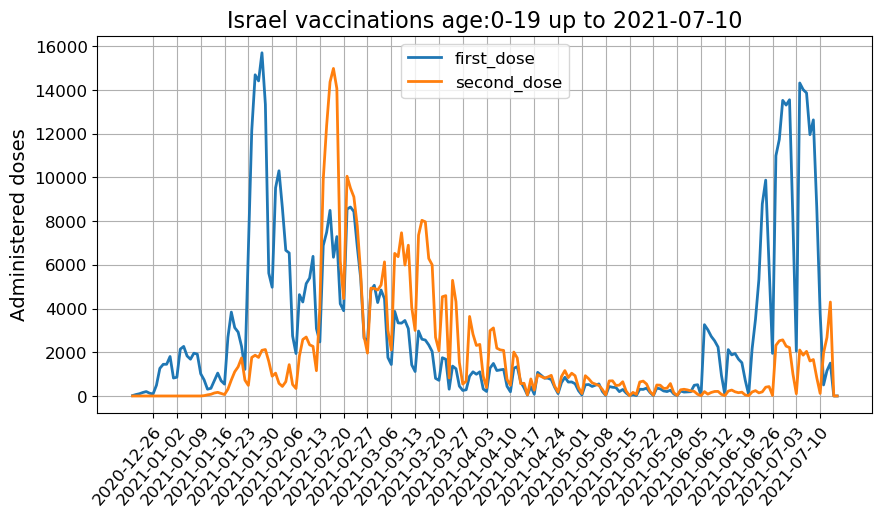

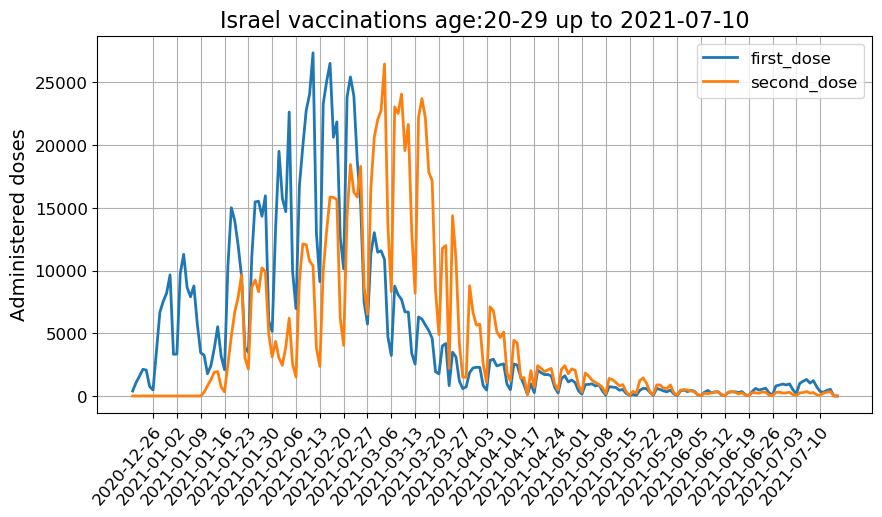

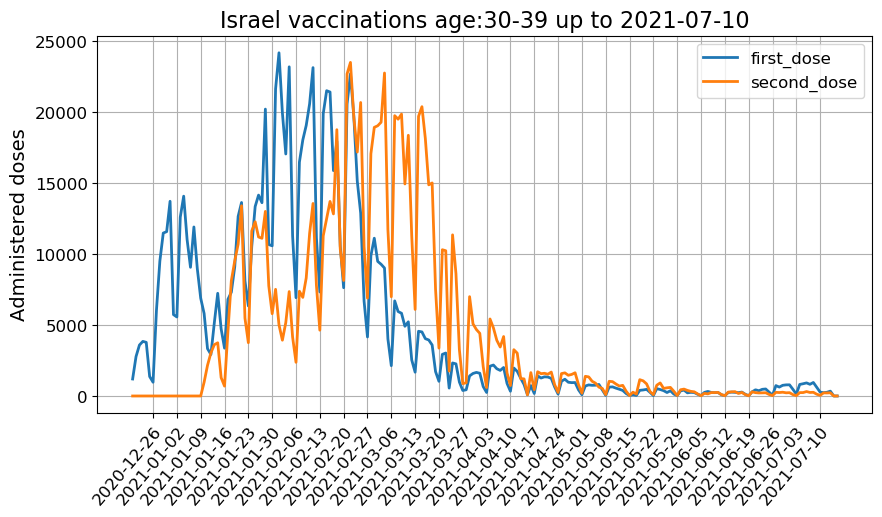

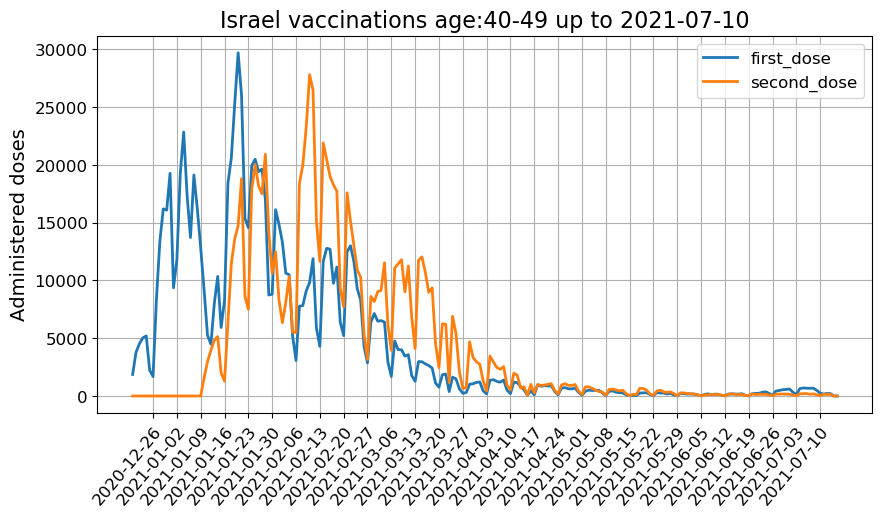

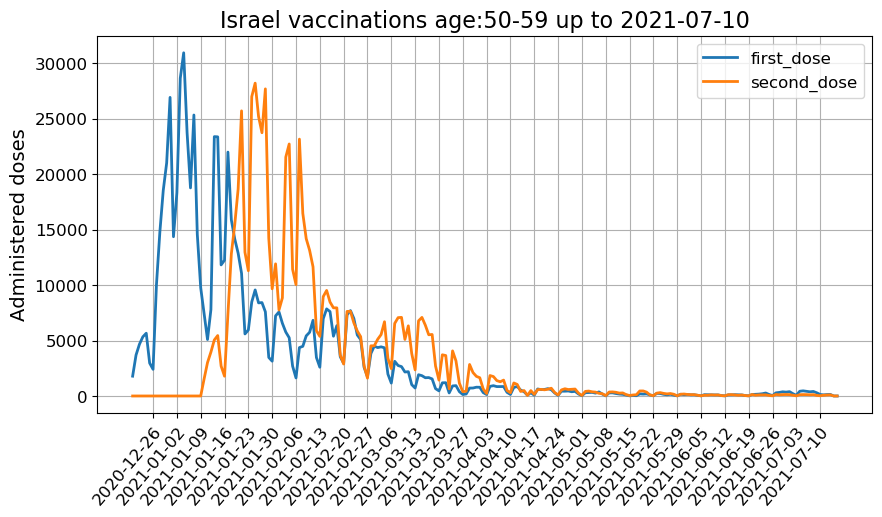

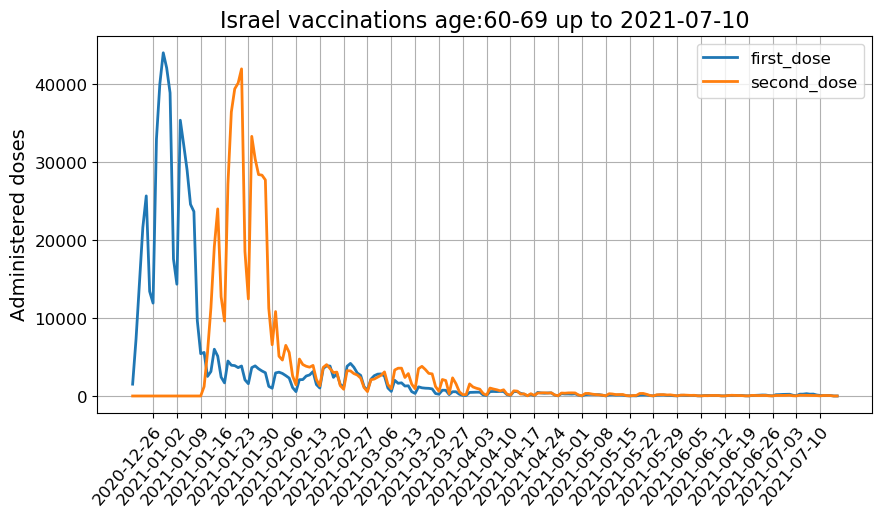

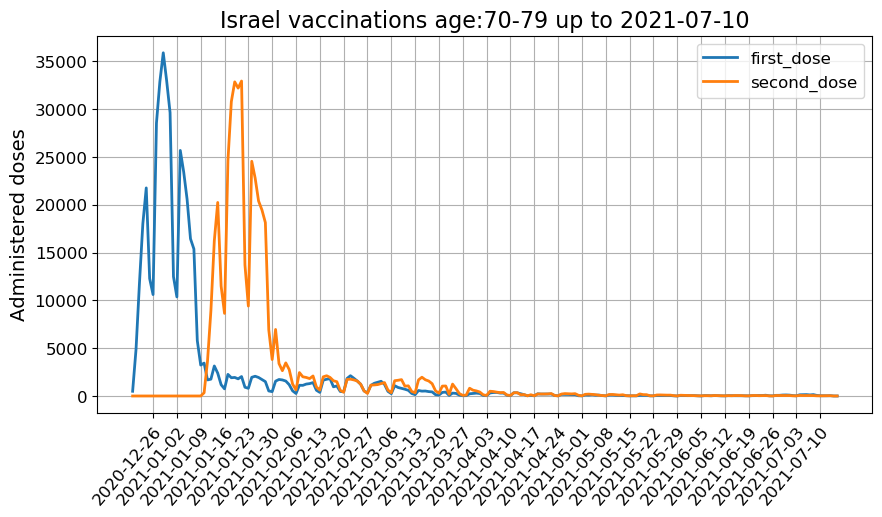

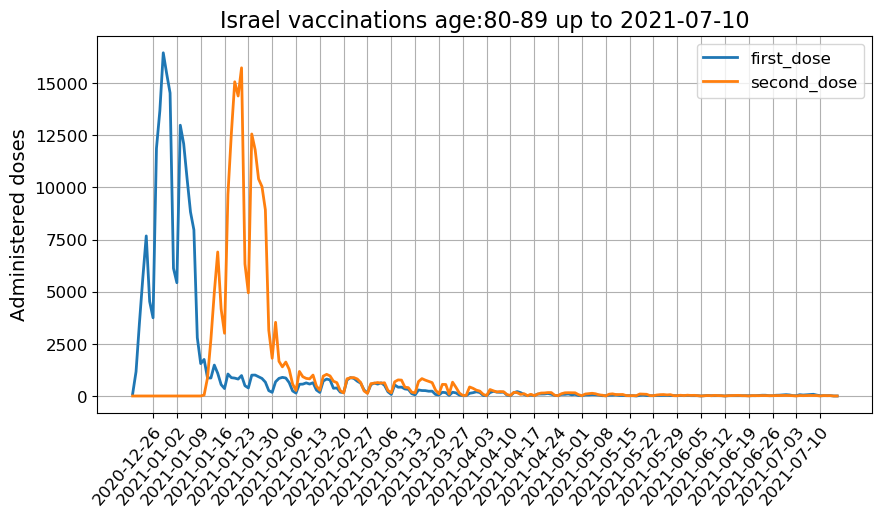

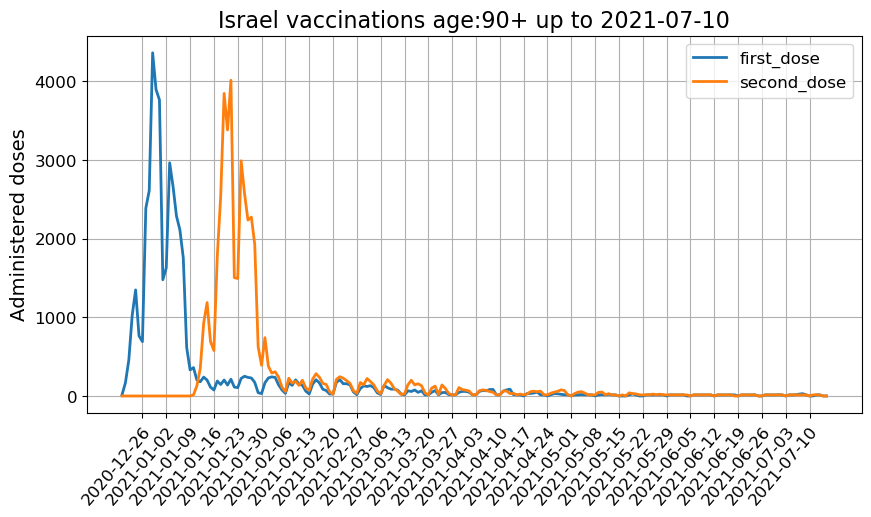

In [47]:
for age in age_groups:
    createXYPlot(df_vax_age[df_vax_age.age_group==age],
             y=["first_dose","second_dose"],
             today="",
             plots_folder=plot_folder,
             x="VaccinationDate",
             linewidth=2,
             start_date="2020-12-01",
             days_interval=7,
             bar=False,
             alpha=1,
             bar_width=0.3,
             bar_start=[-1,0,1],
             title=f"Israel vaccinations age:{age} up to {last_day}",
             savename=f"Israel_vaccinations_{age}",
             ytitle="Administered doses"
            )

In [569]:
df_vax_age_week = df_vax_age.groupby(["week","age_group"]).agg(first_day=("VaccinationDate","min"),
                                                               last_day=("VaccinationDate","max"),
                                                               first_dose=("first_dose","sum"),
                                                               second_dose=("second_dose","sum")
                                                              ).reset_index()
df_vax_age_week["week"] = df_vax_age_week["first_day"] + " - " + df_vax_age_week["last_day"]
df_vax_age_week = df_vax_age_week.sort_values(by=["week","age_group"])

In [600]:
df_vax_age_week.tail(30)

,week,age_group,first_day,last_day,first_dose,second_dose
239,2021-06-20 - 2021-06-26,60-69,2021-06-20,2021-06-26,541.0,355.0
240,2021-06-20 - 2021-06-26,70-79,2021-06-20,2021-06-26,278.0,222.0
241,2021-06-20 - 2021-06-26,80-89,2021-06-20,2021-06-26,158.0,115.0
251,2021-06-27 - 2021-07-02,90+,2021-06-27,2021-07-02,91.0,90.0
243,2021-06-27 - 2021-07-03,0-19,2021-06-27,2021-07-03,73146.0,13007.0
244,2021-06-27 - 2021-07-03,20-29,2021-06-27,2021-07-03,5143.0,1525.0
245,2021-06-27 - 2021-07-03,30-39,2021-06-27,2021-07-03,4281.0,1346.0
246,2021-06-27 - 2021-07-03,40-49,2021-06-27,2021-07-03,3058.0,911.0
247,2021-06-27 - 2021-07-03,50-59,2021-06-27,2021-07-03,1985.0,690.0
248,2021-06-27 - 2021-07-03,60-69,2021-06-27,2021-07-03,1091.0,433.0


In [584]:
index_columns=["week","first_day","last_day","age_group"]
df_vax_events=df.set_index(index_columns).join(df_vax_age_week.set_index(index_columns)).fillna(0)

In [585]:
df_vax_events

type_of_event  \
week                    first_day  last_day   age_group                    
2020-12-20 - 2020-12-26 2020-12-20 2020-12-26 0-19       Hospitalization   
                                              0-19                 Death   
                                              20-29      Hospitalization   
                                              20-29                Death   
                                              30-39      Hospitalization   
...                                                                  ...   
2021-07-04 - 2021-07-10 2021-07-04 2021-07-10 70-79                Death   
                                              80-89      Hospitalization   
                                              80-89                Death   
                                              90+        Hospitalization   
                                              90+                  Death   

                                                         event_1st_dose  \
week                    first_day  last_day   age_group                   
2020-12-20 - 2020-12-26 2020-12-20 2020-12-26 0-19                  0.0   
                                              0-19                  0.0   
                                              20-29                 0.0   
                                              20-29                 0.0   
                                              30-39                 0.0   
...                                                                 ...   
2021-07-04 - 2021-07-10 2021-07-04 2021-07-10 70-79                 0.0   
                                              80-89                 0.0   
                                              80-89                 0.0   
                                              90+                   0.0   
                                              90+                   0.0   

                                                         event_2nd_dose  \
week                    first_day  last_day   age_group                   
2020-12-20 - 2020-12-26 2020-12-20 2020-12-26 0-19                  0.0   
                                              0-19                  0.0   
                                              20-29                 0.0   
                                              20-29                 0.0   
                                              30-39                 0.0   
...                                                                 ...   
2021-07-04 - 2021-07-10 2021-07-04 2021-07-10 70-79                 5.0   
                                              80-89                 9.0   
                                              80-89                 5.0   
                                              90+                   5.0   
                                              90+                   0.0   

                                                         event_no_vax  \
week                    first_day  last_day   age_group                 
2020-12-20 - 2020-12-26 2020-12-20 2020-12-26 0-19               56.0   
                                              0-19                0.0   
                                              20-29              50.0   
                                              20-29               5.0   
                                              30-39              79.0   
...                                                               ...   
2021-07-04 - 2021-07-10 2021-07-04 2021-07-10 70-79               0.0   
                                              80-89               5.0   
                                              80-89               0.0   
                                              90+                 0.0   
                                              90+                 0.0   

                                                         first_dose  \
week                    first_day  last_day   age_group               
2020-12-20 - 2020-12-26 20

### Population

In [586]:
df_isr_pop=pd.read_csv("./data/israeli_pop.csv")

In [587]:
df_isr_pop = df_isr_pop[df_isr_pop.age != "total"]
df_isr_pop["age"] = df_isr_pop["age"].apply(lambda x: 90 if x == "90+" else int(x)).astype('int')

In [588]:
pop_dict = {}
for age_bucket in age_groups:
    if age_bucket != "90+":
        age_lo = int(age_bucket.split("-")[0])
        age_hi = int(age_bucket.split("-")[1])
    else:
        age_lo = 90
        age_hi = 99999
    #print(age_lo, age_hi)
    df_pop = df_isr_pop[(df_isr_pop.age >= age_lo) &  (df_isr_pop.age <= age_hi)]
    pop_dict[age_bucket] = np.sum(df_pop["pop"])
    
df_pop_strata=pd.DataFrame.from_dict(pop_dict,orient="index",columns=["population"])
df_pop_strata

,population
0-19,3292329
20-29,1277634
30-39,1186386
40-49,1080768
50-59,832687
60-69,735380
70-79,462148
80-89,222547
90+,50589


In [589]:
df_vax_events = df_vax_events.reset_index().set_index("age_group").join(df_pop_strata)

In [590]:
df_vax_events=df_vax_events.reset_index().rename(columns={"index":'age_group'})

In [592]:
events=df_vax_events.type_of_event.unique()

Event: Hospitalization
Age group: 0-19


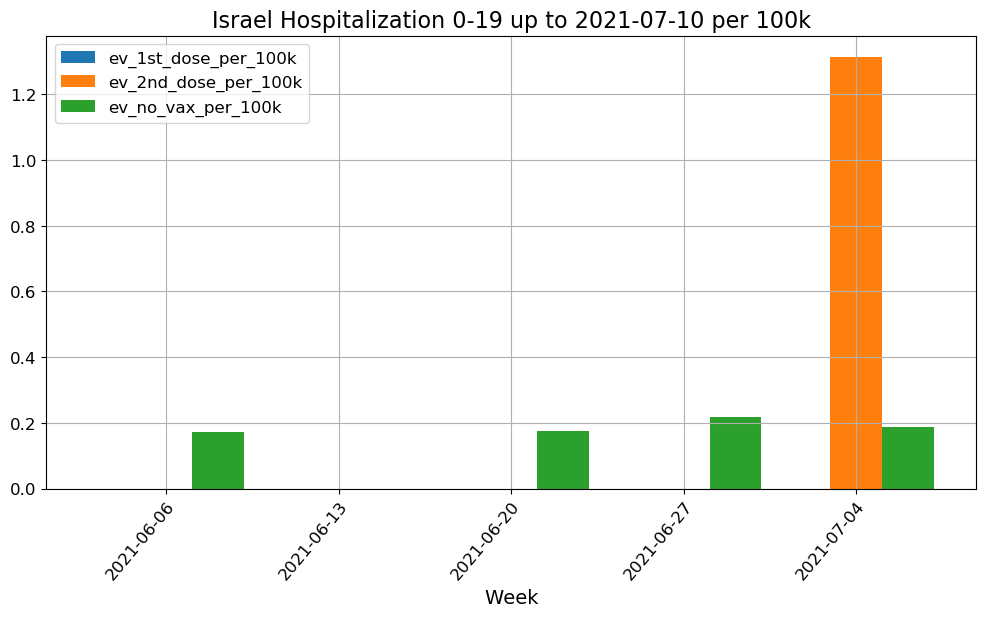

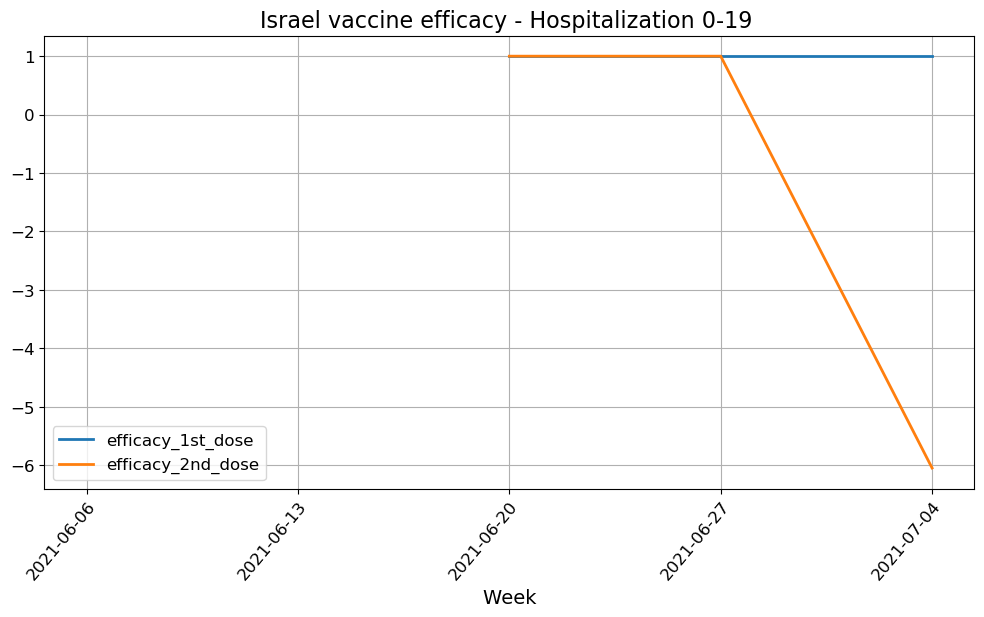

Event: Hospitalization
Age group: 20-29


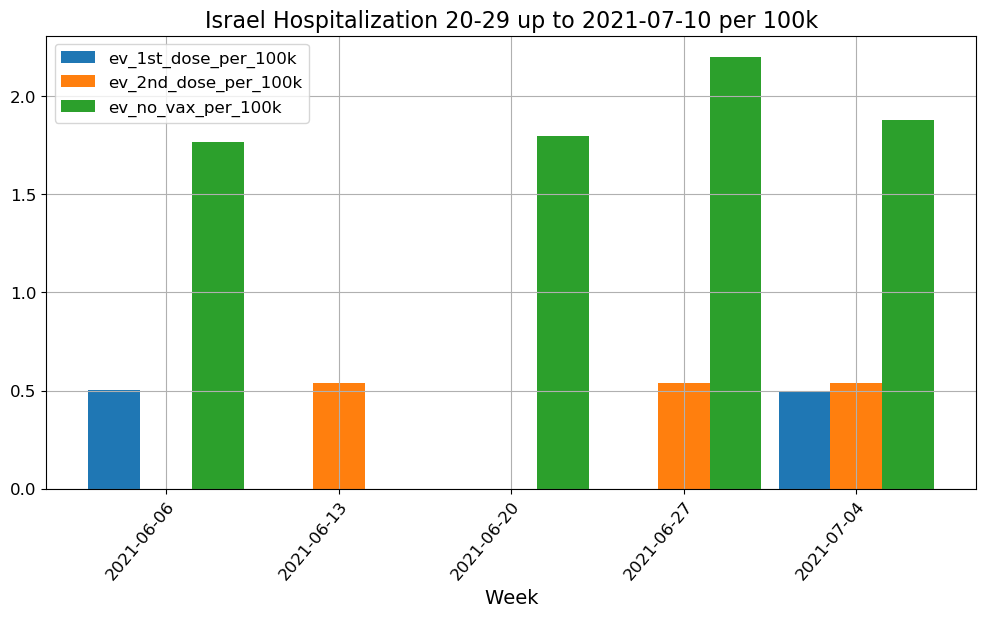

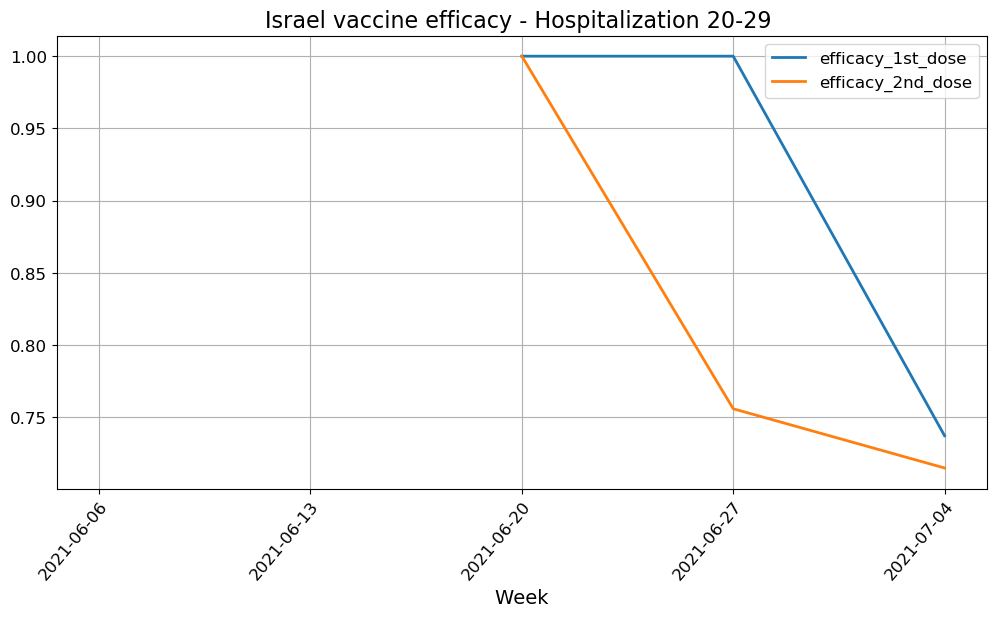

Event: Hospitalization
Age group: 30-39


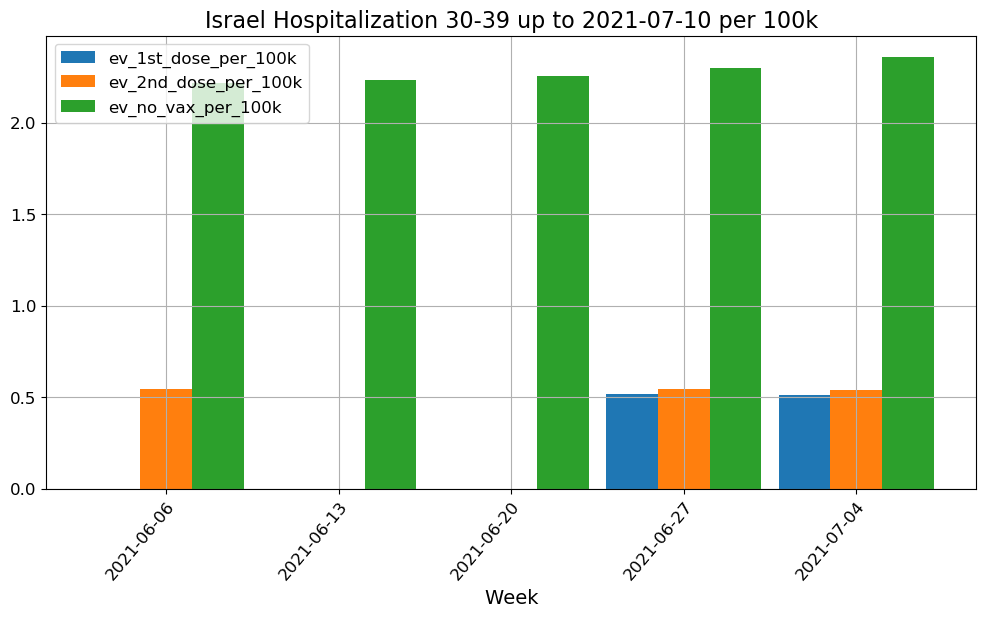

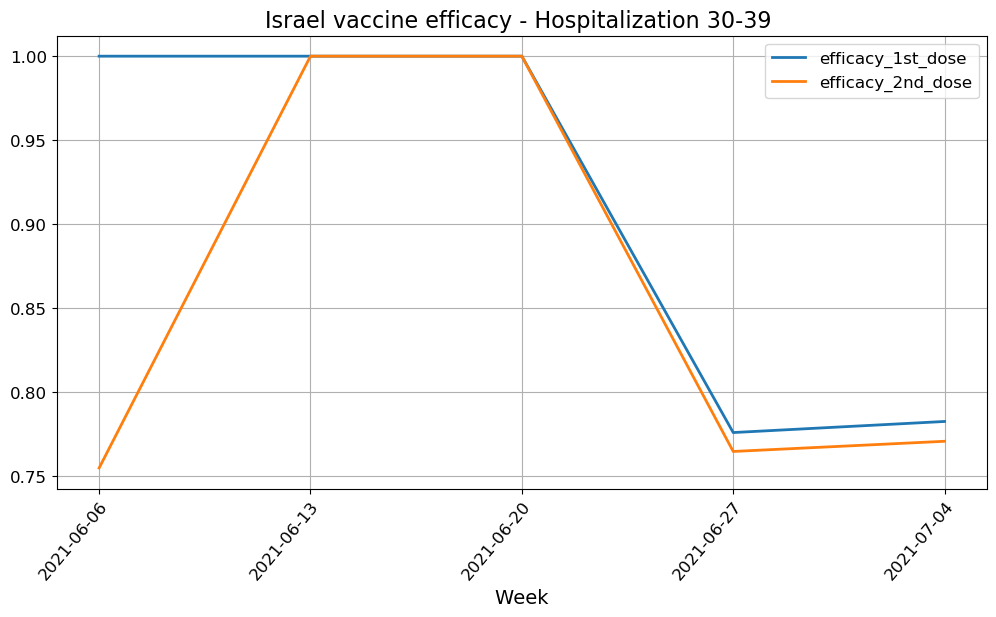

Event: Hospitalization
Age group: 40-49


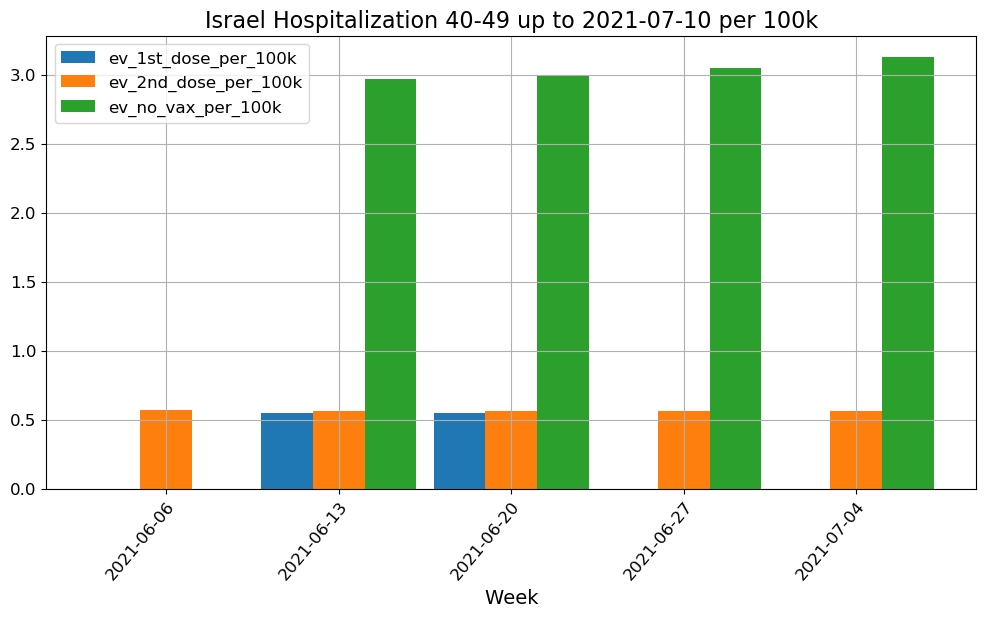

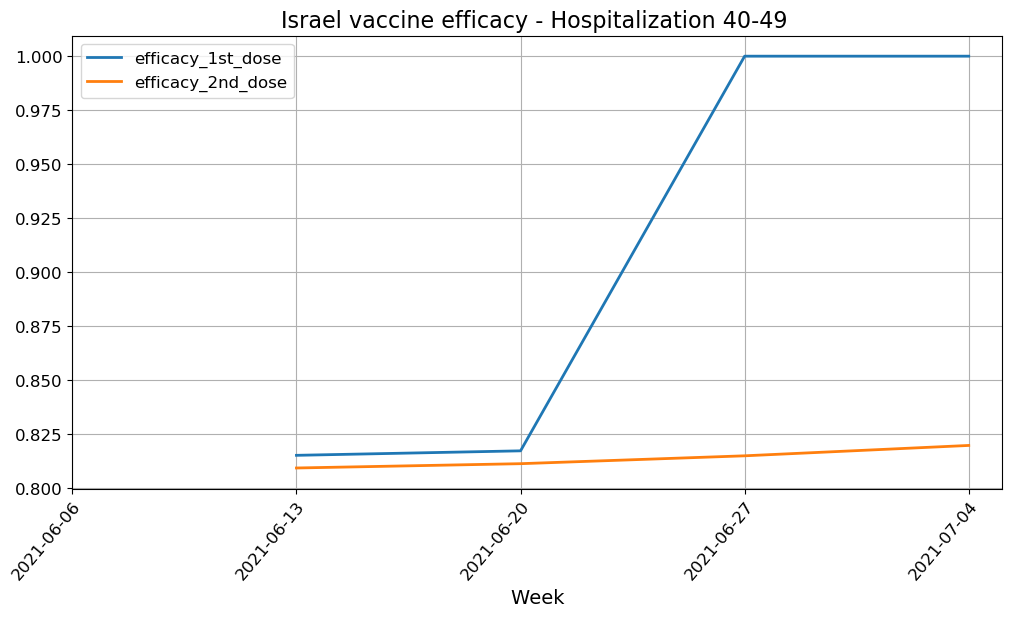

Event: Hospitalization
Age group: 50-59


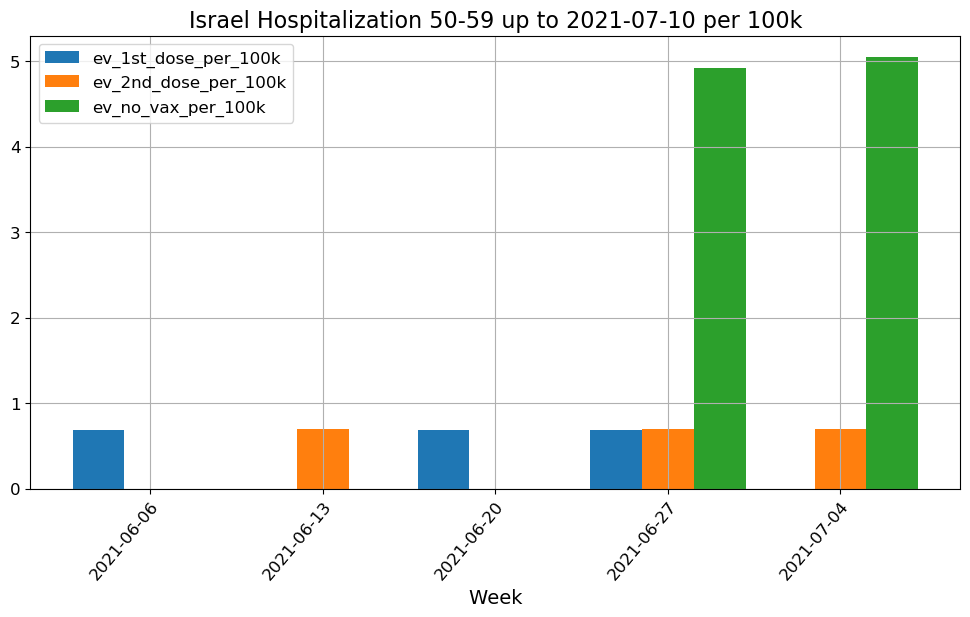

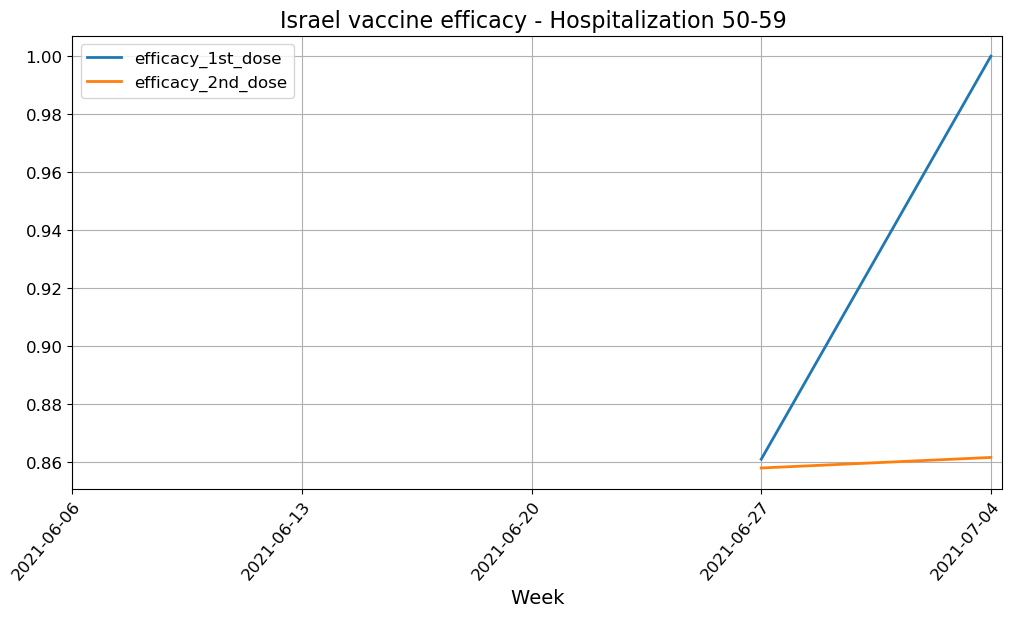

Event: Hospitalization
Age group: 60-69


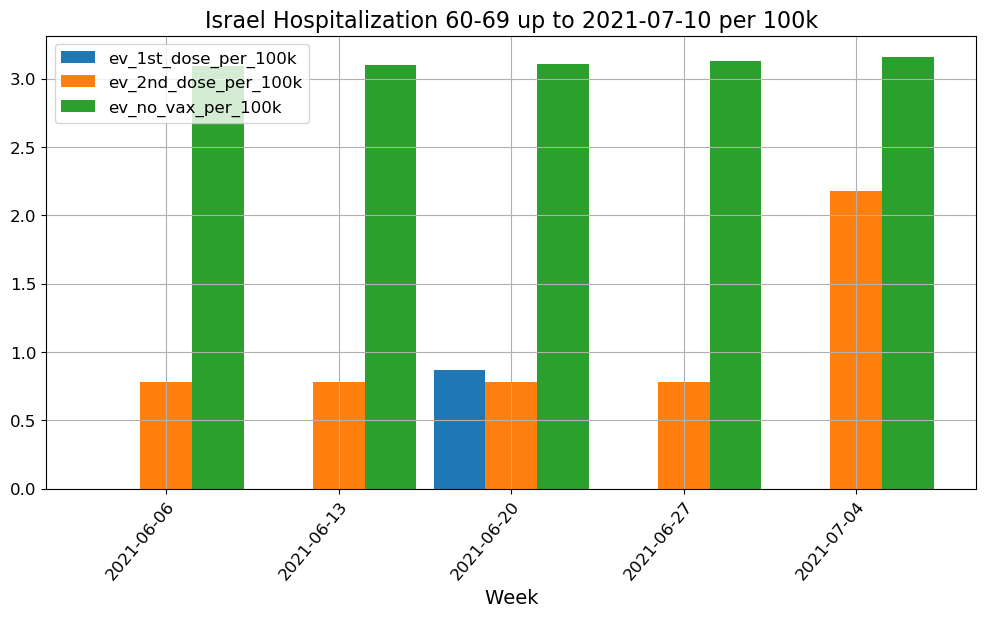

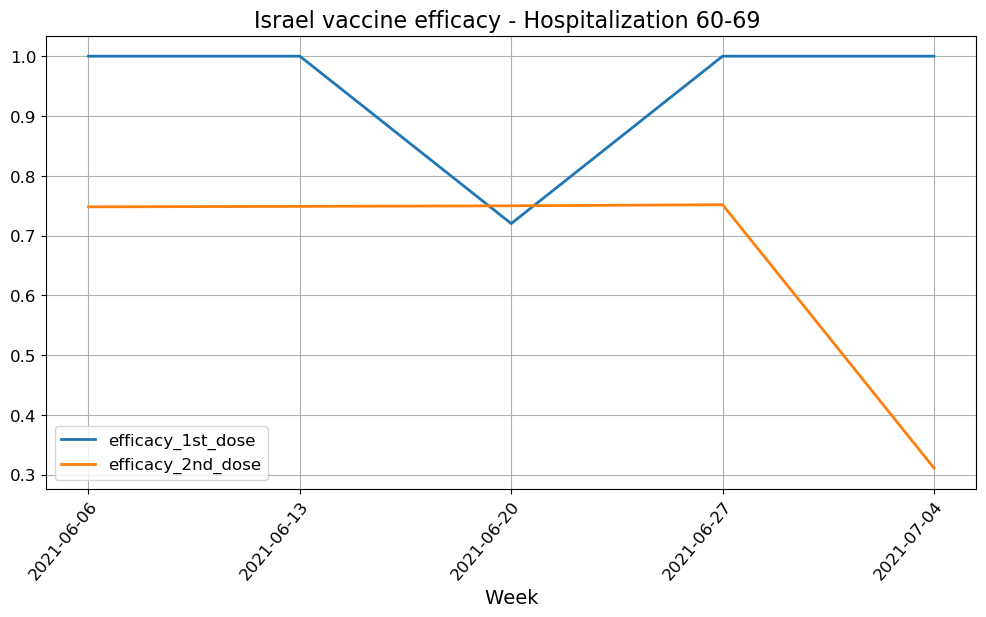

Event: Hospitalization
Age group: 70-79


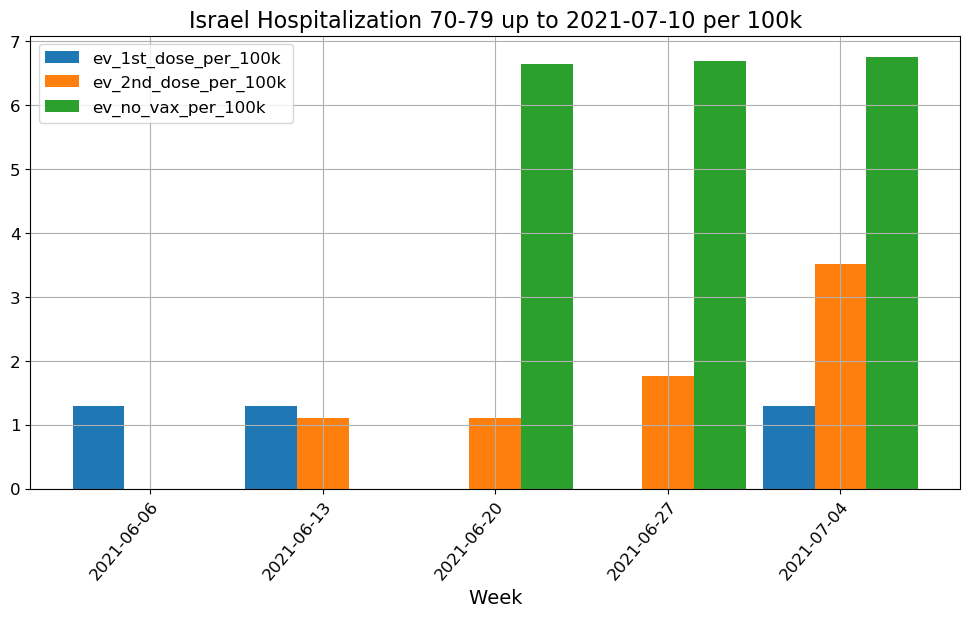

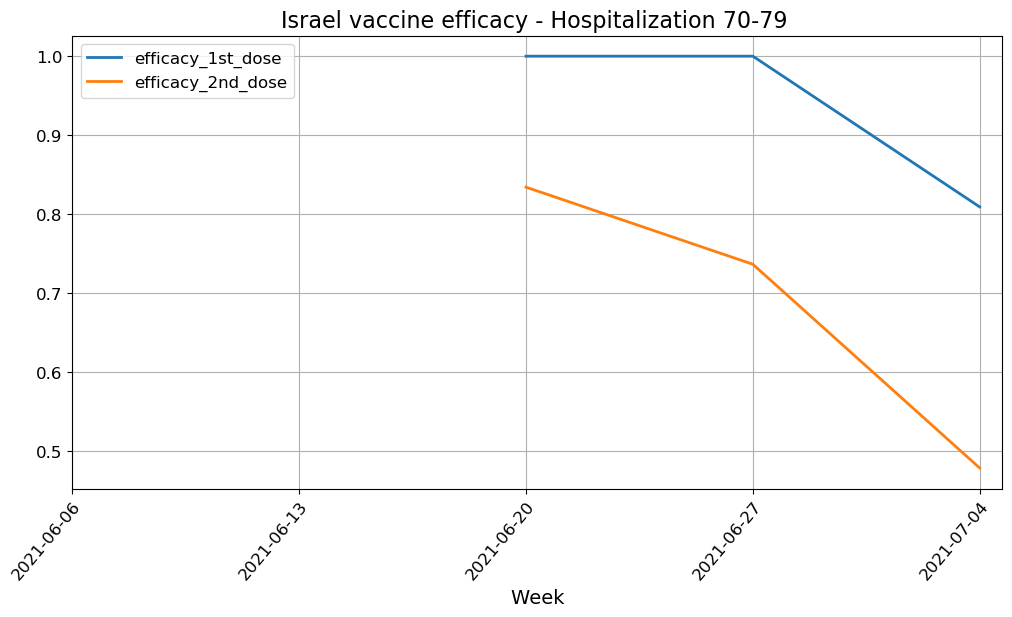

Event: Hospitalization
Age group: 80-89


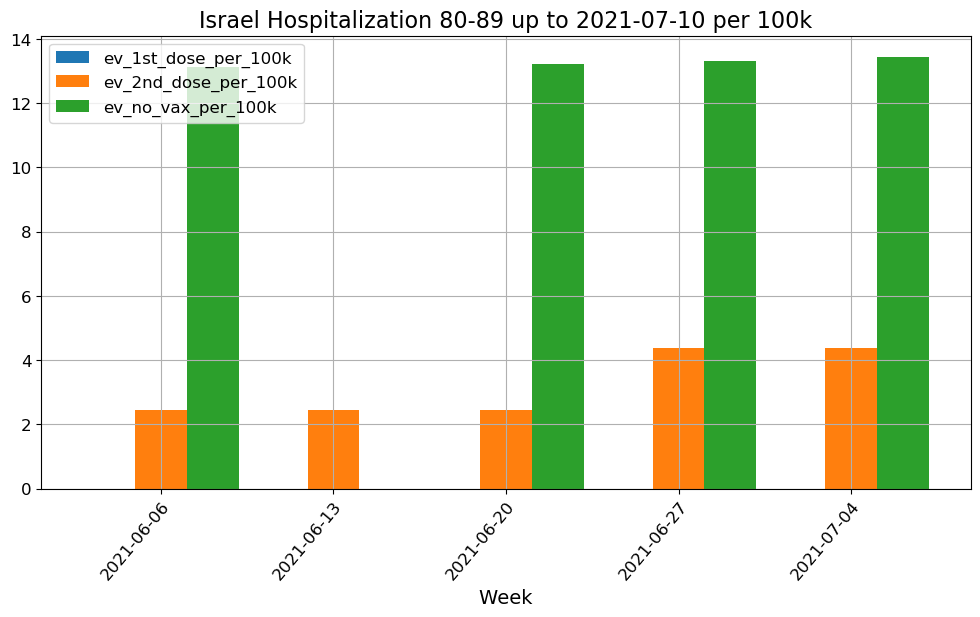

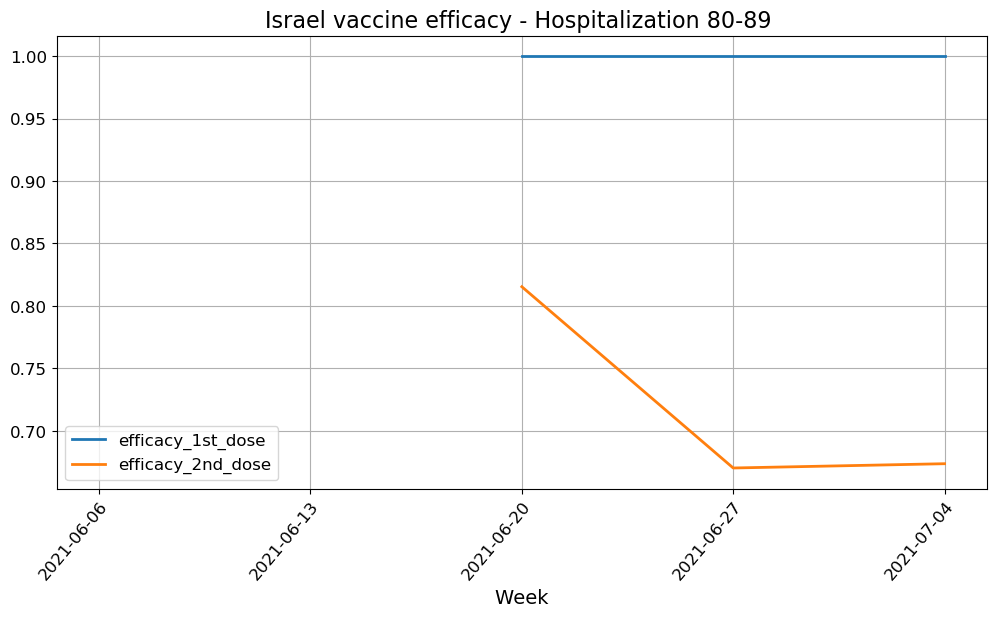

Event: Hospitalization
Age group: 90+


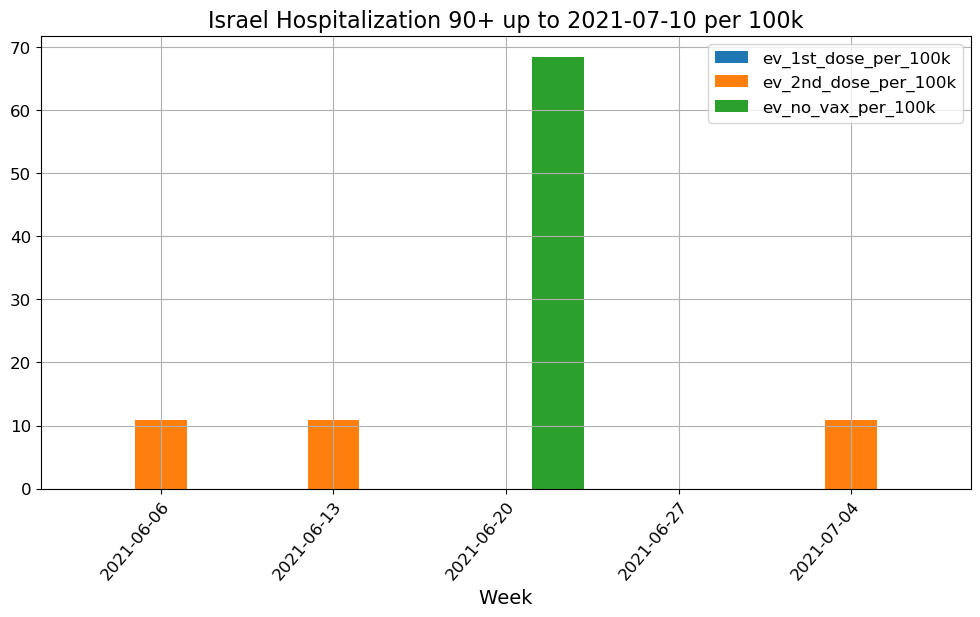

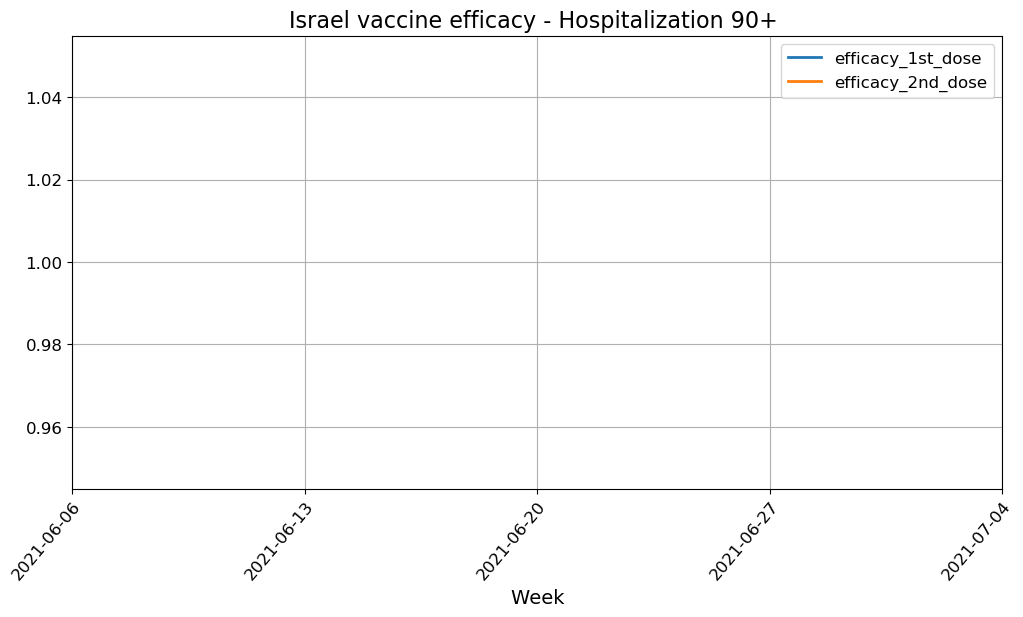

Event: Death
Age group: 0-19


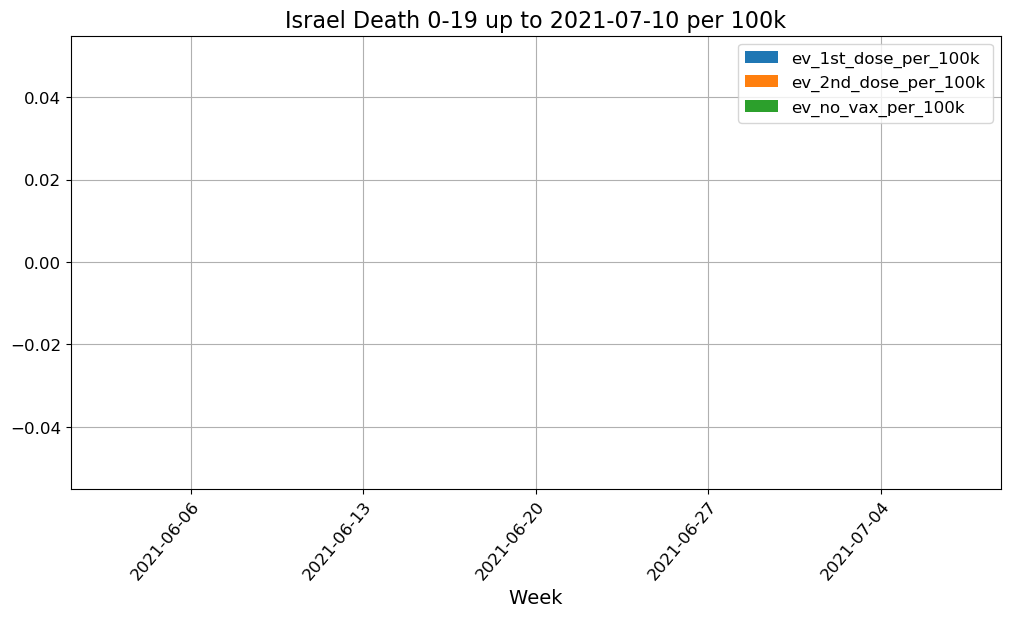

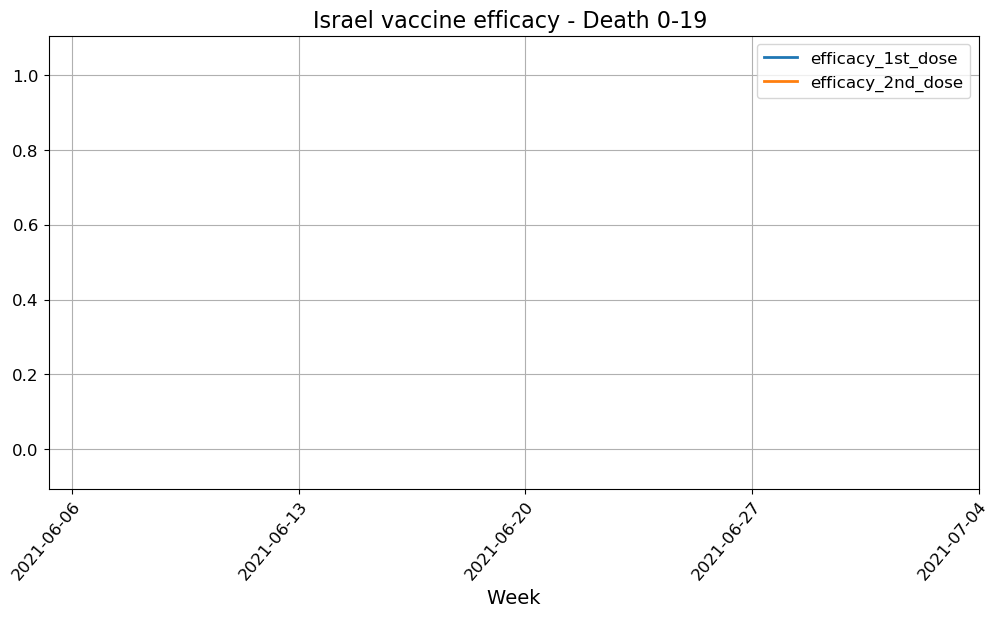

Event: Death
Age group: 20-29


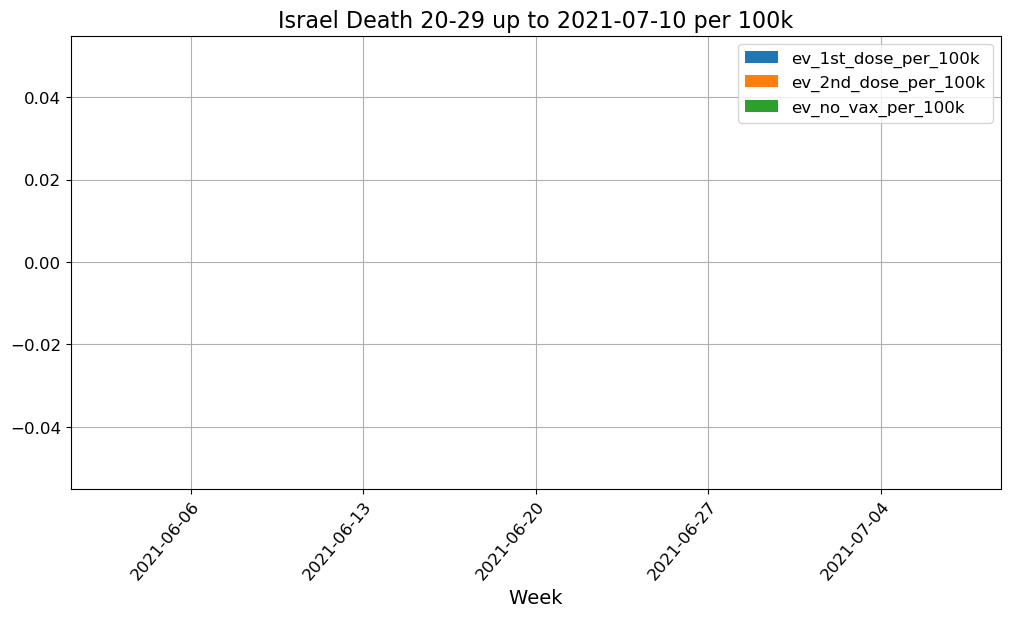

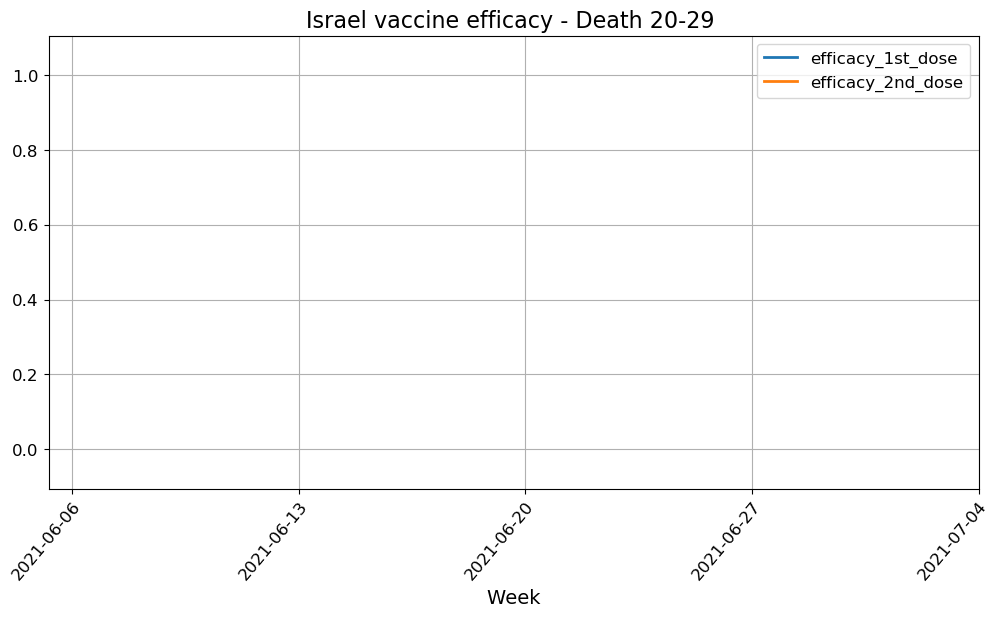

Event: Death
Age group: 30-39


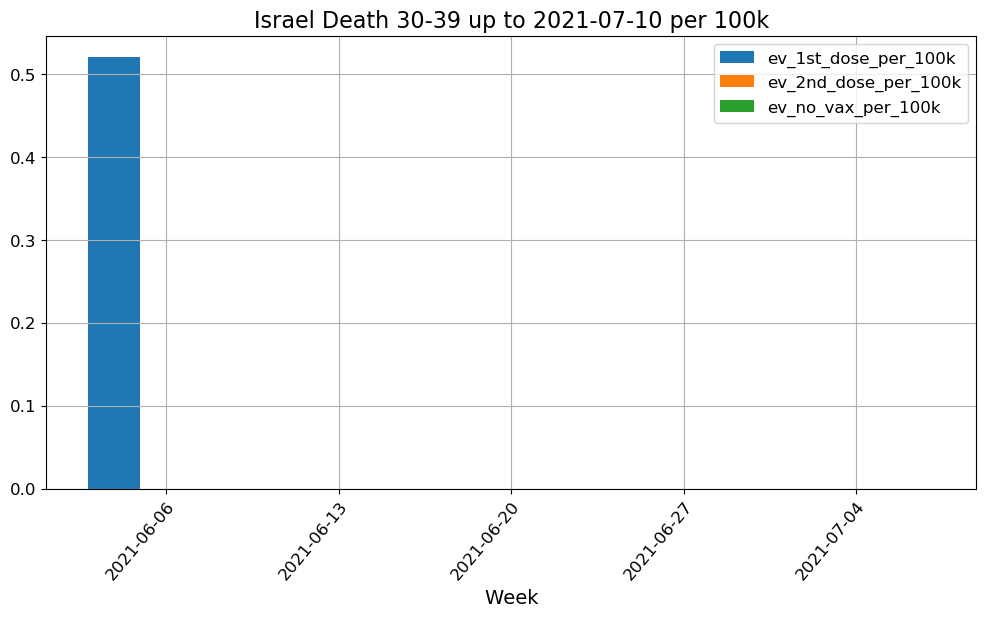

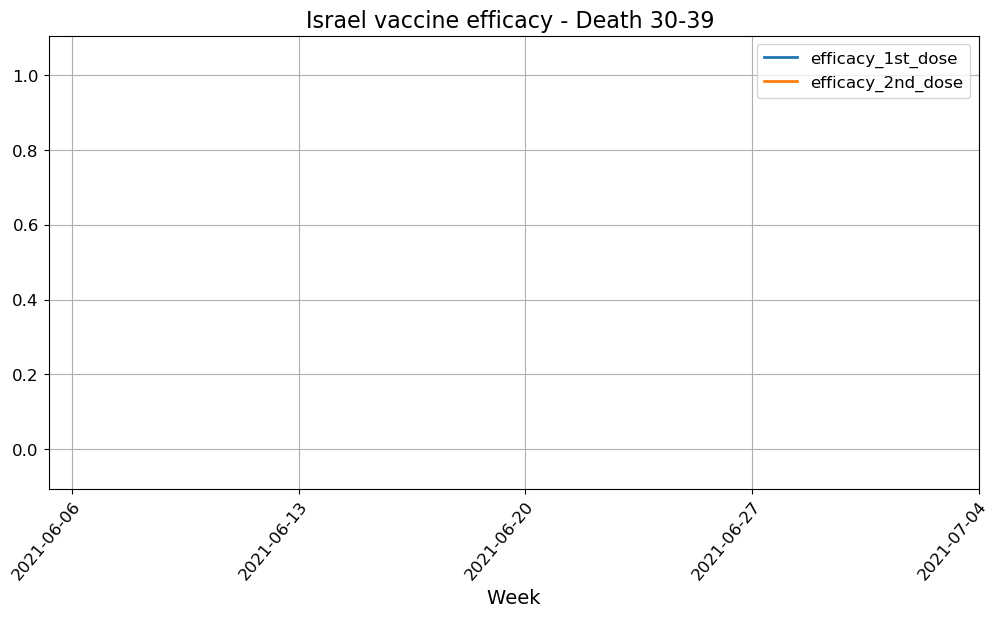

Event: Death
Age group: 40-49


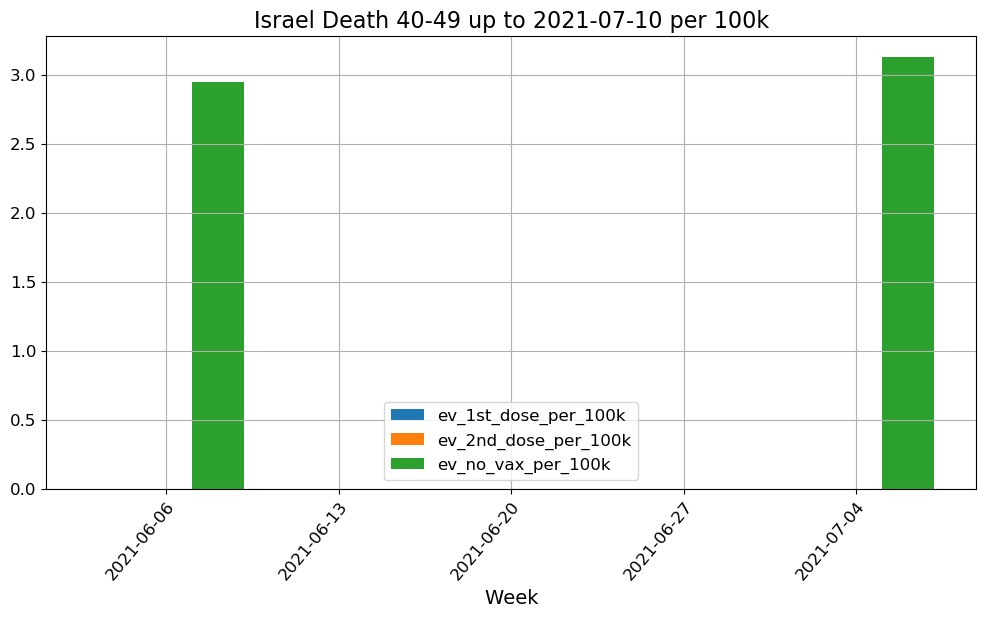

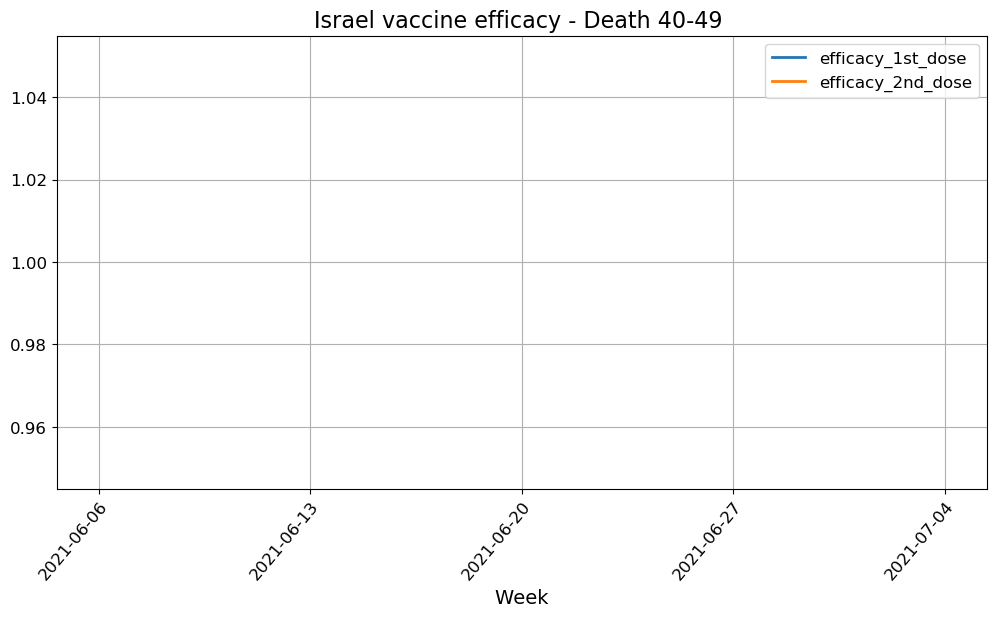

Event: Death
Age group: 50-59


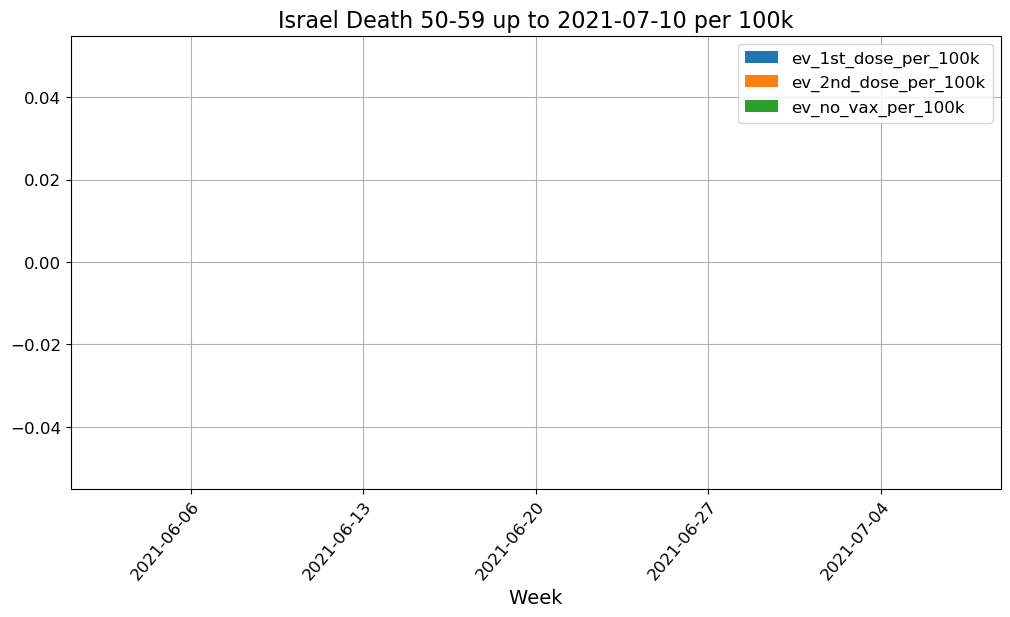

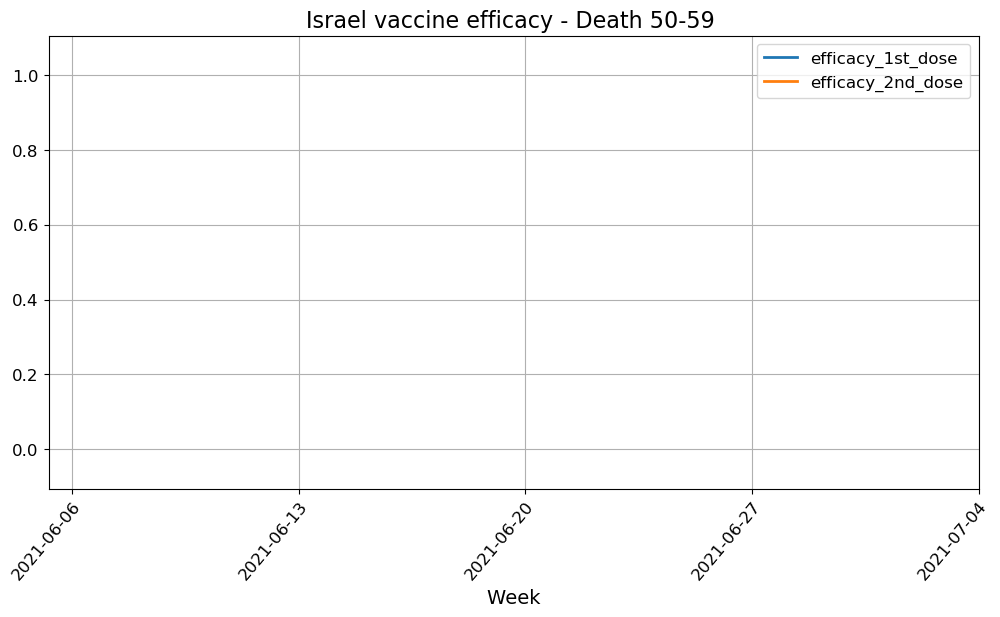

Event: Death
Age group: 60-69


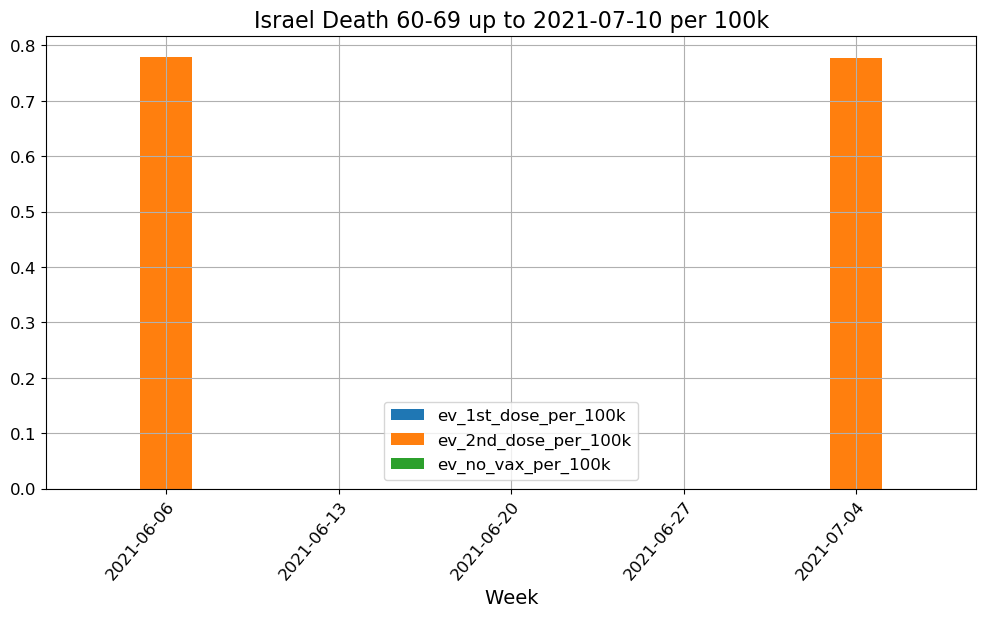

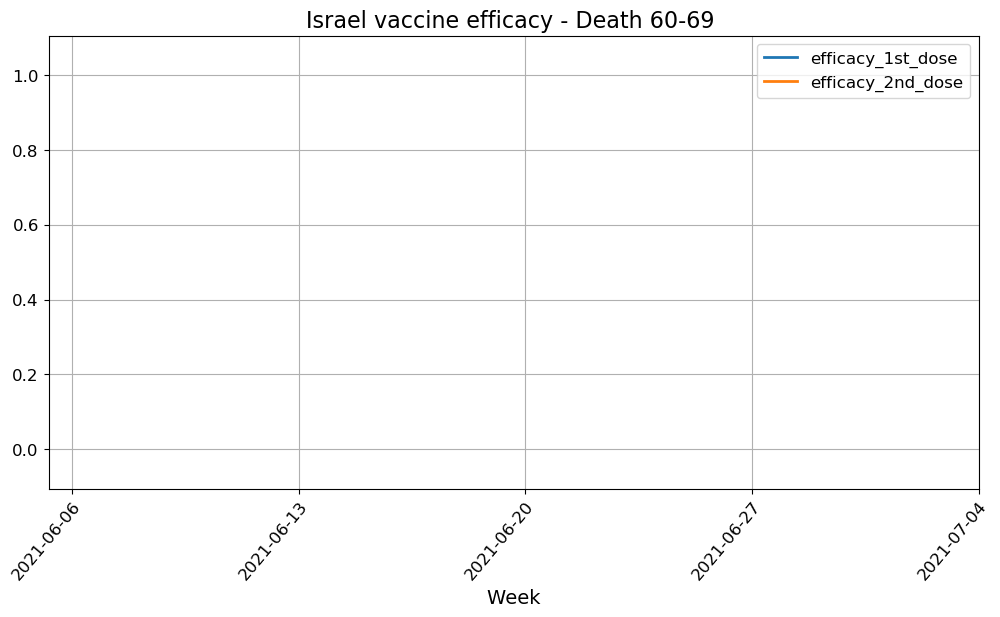

Event: Death
Age group: 70-79


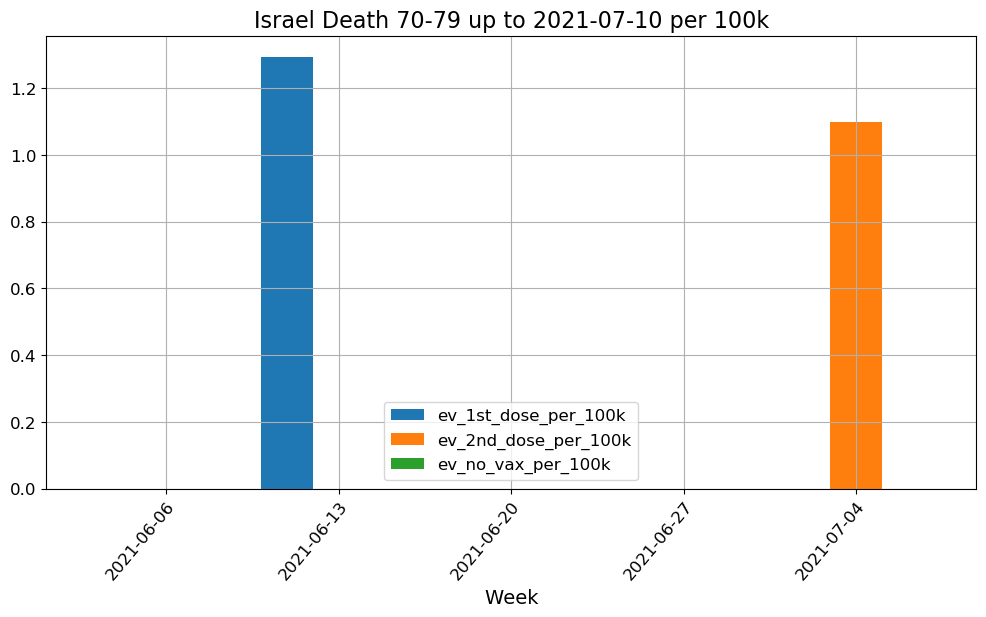

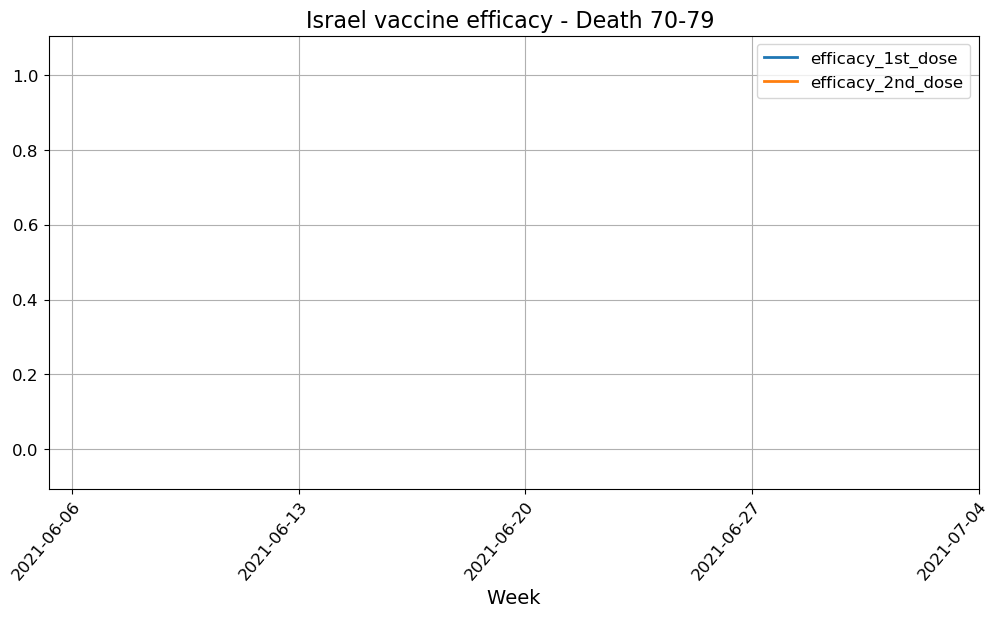

Event: Death
Age group: 80-89


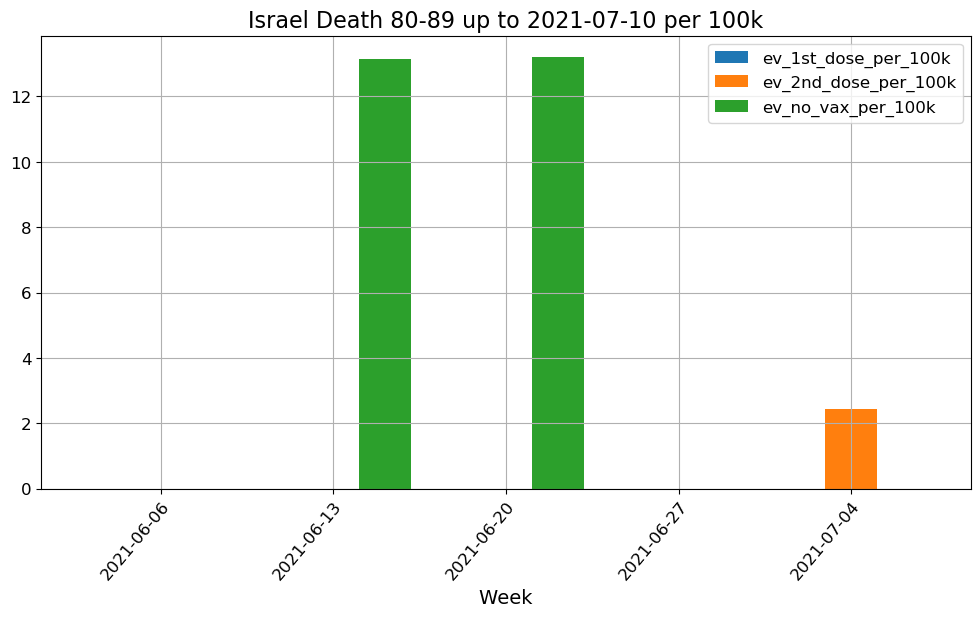

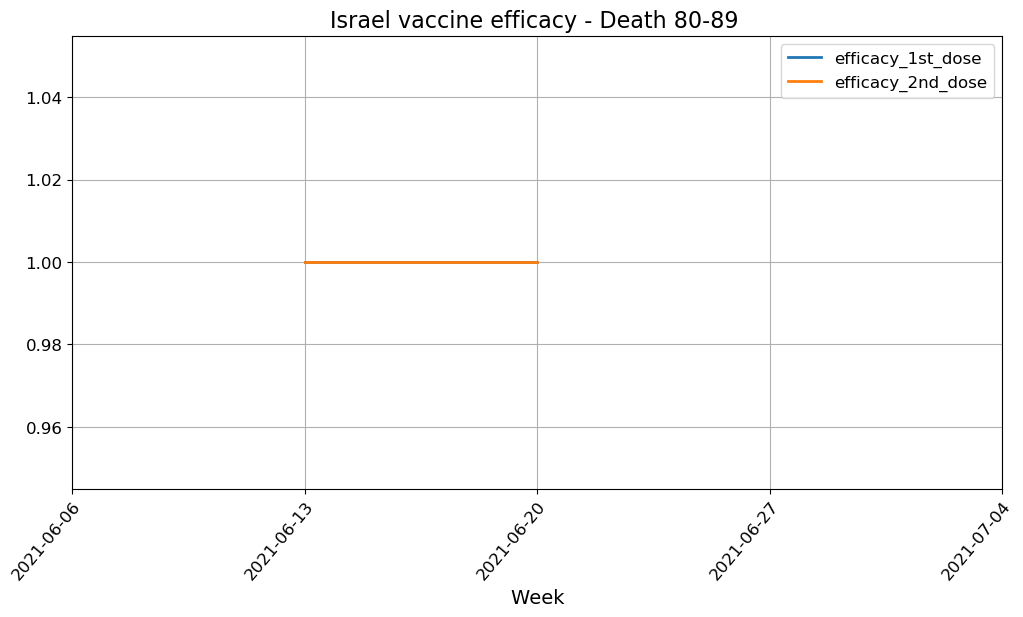

Event: Death
Age group: 90+


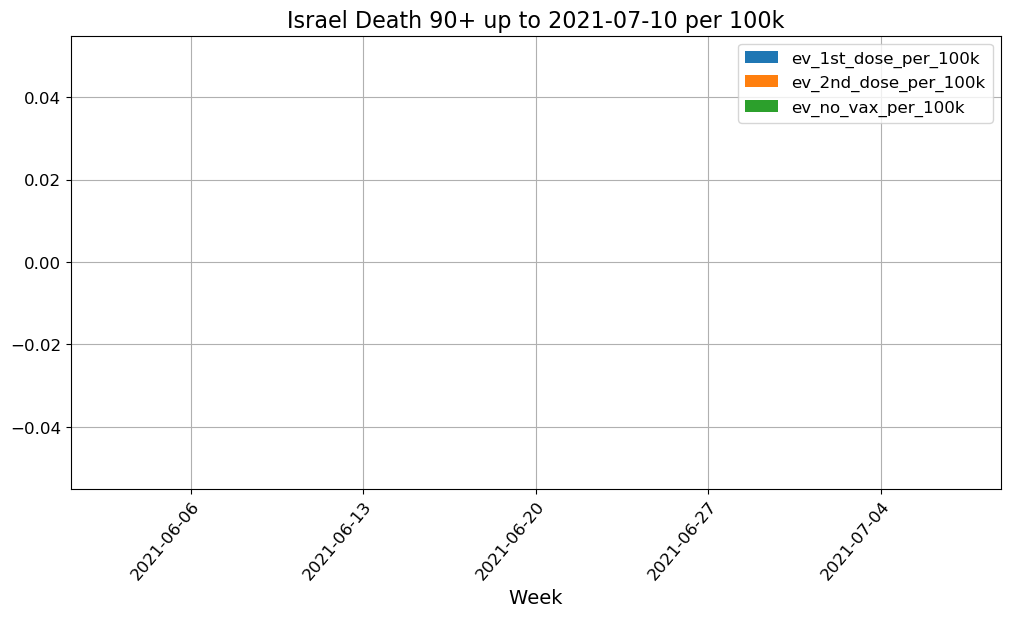

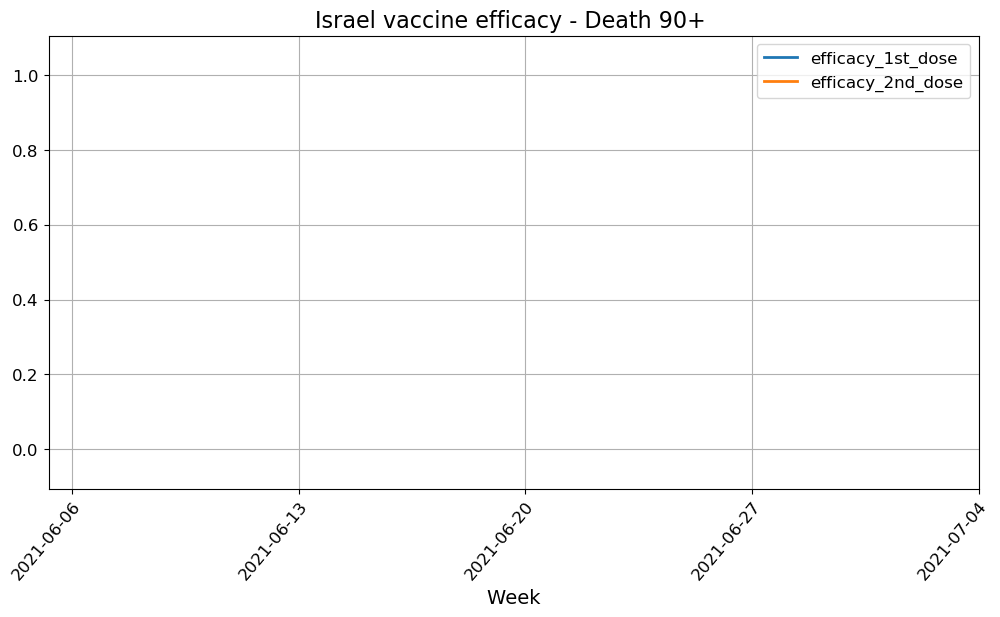

In [677]:
final_df_dict = {}
for event in events:
    df_dict_ages={}
    for age in age_groups:
        print(f"Event: {event}")
        print(f"Age group: {age}")
        df_final = df_vax_events[(df_vax_events.age_group==age) & (df_vax_events.type_of_event==event)]
        df_final = df_final.sort_values(by=["first_day"])
        
        df_final["pop_1st_dose"] = df_final["first_dose"].cumsum()
        df_final["pop_2nd_dose"] = df_final["second_dose"].cumsum()
        df_final["pop_no_vax"] = df_final["population"] - df_final["pop_1st_dose"]
        
        for status in ["1st_dose", "2nd_dose", "no_vax"]:
            df_final[f"frac_{status}"] = df_final[f"pop_{status}"]/df_final["population"]
        
            df_final[f"ev_{status}_per_100k"] =  (1e5) * df_final[f"event_{status}"]/df_final[f"pop_{status}"]
            
            p = df_final[f"event_{status}"]/df_final[f"pop_{status}"]
            q = 1 - p
            N = df_final[f"pop_{status}"]
            df_final[f"err_{status}_per_100k"] = (1e5) * np.sqrt(p*q) / np.sqrt(N)
        
            
        for status in ["1st_dose", "2nd_dose"]:
            df_final[f"efficacy_{status}"] =  1 - df_final[f"ev_{status}_per_100k"]/df_final["ev_no_vax_per_100k"]
            A = 1-df_final[f"ev_{status}_per_100k"]
            B = df_final["ev_no_vax_per_100k"]
            sA = df_final[f"err_{status}_per_100k"]
            sB = df_final[f"err_no_vax_per_100k"]
            f = df_final[f"efficacy_{status}"]
            df_final[f"err_efficacy_{status}"] = np.abs(f) * np.sqrt((sA/A)**2 + (sB/B)**2)
            
            df_final[f"arr_{status}"] = (df_final[f"ev_no_vax_per_100k"] - df_final[f"ev_{status}_per_100k"])/(1e5)
            df_final[f"nntv_{status}"] = 1/df_final[f"arr_{status}"]
        
        df_dict_ages[age] = df_final
        createXYPlot(df_final,
                     y=["ev_1st_dose_per_100k",
                        "ev_2nd_dose_per_100k",
                        "ev_no_vax_per_100k"],
                     today="",
                     plots_folder="./plots",
                     x="first_day",
                     linewidth=2,
                     startDate="2021-06-01",
                     daysInterval=1,
                     bar=True,
                     alpha=1,
                     barWidth=0.3,
                     barStart=[-1,0,1],
                     title=f"Israel {event} {age} up to {last_week} per 100k",
                     xtitle="Week",
                     savename=None
            )
        
        createXYPlot(df_final,
                     y=["efficacy_1st_dose",
                        "efficacy_2nd_dose"],
                     today="",
                     plots_folder="./plots",
                     x="first_day",
                     linewidth=2,
                     startDate="2021-06-01",
                     daysInterval=1,
                     bar=False,
                     alpha=1,
                     barWidth=0.3,
                     barStart=[-1,0,1],
                     title=f"Israel vaccine efficacy - {event} {age} ",
                     xtitle="Week",
                     savename=None
            )
    final_df_dict[event] = df_dict_ages
    

In [678]:
final_df_dict["Death"]["40-49"][["week","ev_2nd_dose_per_100k","ev_no_vax_per_100k","pop_2nd_dose","efficacy_2nd_dose","err_efficacy_2nd_dose","arr_2nd_dose","nntv_2nd_dose"]]

,week,ev_2nd_dose_per_100k,ev_no_vax_per_100k,pop_2nd_dose,efficacy_2nd_dose,err_efficacy_2nd_dose,arr_2nd_dose,nntv_2nd_dose
175,2020-12-20 - 2020-12-26,NaN,0.462634,0.0,NaN,NaN,NaN,NaN
177,2020-12-27 - 2021-01-02,NaN,0.608329,0.0,NaN,NaN,NaN,NaN
179,2021-01-03 - 2021-01-09,NaN,0.578012,0.0,NaN,NaN,NaN,NaN
181,2021-01-10 - 2021-01-16,0.000000,0.614563,21727.0,1.000000,0.447212,0.000006,1.627172e+05
183,2021-01-17 - 2021-01-23,0.000000,0.904064,102807.0,1.000000,0.408246,0.000009,1.106117e+05
185,2021-01-24 - 2021-01-30,2.251208,0.909599,222103.0,-1.474946,1.357774,-0.000013,-7.453736e+04
187,2021-01-31 - 2021-02-06,0.000000,1.470514,278694.0,1.000000,0.377962,0.000015,6.800343e+04
189,2021-02-07 - 2021-02-13,0.000000,1.191975,421299.0,1.000000,0.447211,0.000012,8.389440e+04
191,2021-02-14 - 2021-02-20,0.000000,1.429229,535711.0,1.000000,0.447210,0.000014,6.996780e+04
193,2021-02-21 - 2021-02-27,0.000000,2.430328,611125.0,1.000000,0.377960,0.000024,4.114671e+04


In [642]:
(1/1e6)*(1-(1/1e6))

9.99999e-07